# **Rete Neurale**

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [26]:
#Normal libraries

from pandas import read_csv
import pandas as pd
import numpy as np

#Library to build a model using keras that is build on tensorflow (a library on how to handle tensor and their function)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

#Libraries about the learning process of the actual AI
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#Useful libraries, in these days I'll try to learn pyplot, probably could be way better
from matplotlib import pyplot as plt
import math

In [27]:
#Read all the csv, fix them and merge them into only one dataset. They have different transformation of the Time column just because they are downloaded from different platforms
#These Dataset are easier to handle, have little less information but are still usefull to start

df8 = read_csv("13gen_29apr_appa1.csv",sep="\t",header=0)
df9 = read_csv("29apr_1lug_appa1.csv",sep="\t",header=0)
df10 = read_csv("1lug_22set_appa1.csv",sep="\t",header=0)
df11 = read_csv("23-09_12-04_appa1.csv",sep=",",header=0)
df11 = df11.drop("Unnamed: 0",axis = 1)

df11.Time = pd.to_datetime(df11.Time, format = "%Y-%m-%d %H:%M:%S")



df8 = pd.concat((df8,df9,df10))
df8.Time = pd.to_datetime(df8.Time, format = "%b %d %Y %H:%M:%S")
df8 = pd.concat((df8,df11))
df8 = df8.set_index("Time")
df8 = df8.drop("TEMP_BME",axis = 1).drop("HUM_BME", axis = 1)

print(df8)

print(df8.describe())

a1 = "mean_absolute_error"
a2 = "mean_squared_error"
aper = "mean_absolute_percentage_error"

                               R1             R2            R3            R4  \
Time                                                                           
2021-01-13 00:00:00           NaN            NaN           NaN           NaN   
2021-01-13 01:00:00           NaN            NaN           NaN           NaN   
2021-01-13 02:00:00           NaN            NaN           NaN           NaN   
2021-01-13 03:00:00           NaN            NaN           NaN           NaN   
2021-01-13 04:00:00           NaN            NaN           NaN           NaN   
...                           ...            ...           ...           ...   
2022-04-12 18:00:00  3.431883e+06  663690.216667  2.101452e+07  8.086864e+07   
2022-04-12 19:00:00  3.501193e+06  686711.716667  2.012816e+07  7.427008e+07   
2022-04-12 20:00:00  3.599954e+06  735469.898305  1.677982e+07  5.032817e+07   
2022-04-12 21:00:00  3.931479e+06  818755.800000  1.338811e+07  2.912555e+07   
2022-04-12 22:00:00  4.257555e+06  90506

In [28]:
df10.tail

<bound method NDFrame.tail of                       Time            R1            R2            R3  \
0     Jul 01 2021 00:00:00  2.133333e+07  2.133333e+07  8.835461e+06   
1     Jul 01 2021 01:00:00  2.304000e+07  2.133333e+07  8.432733e+06   
2     Jul 01 2021 02:00:00  2.197333e+07  1.991111e+07  1.022122e+07   
3     Jul 01 2021 03:00:00  2.282667e+07  2.072381e+07  8.592902e+06   
4     Jul 01 2021 04:00:00  2.304000e+07  2.057143e+07  7.465936e+06   
...                    ...           ...           ...           ...   
2003  Sep 22 2021 11:00:00  7.908322e+06  7.963747e+06  1.279946e+07   
2004  Sep 22 2021 12:00:00  6.403030e+06  6.476822e+06  1.827521e+07   
2005  Sep 22 2021 13:00:00  5.186537e+06  5.219521e+06  2.594370e+07   
2006  Sep 22 2021 14:00:00  3.808286e+06  3.745916e+06  3.864418e+07   
2007  Sep 22 2021 15:00:00  3.121951e+06  3.047619e+06  4.688645e+07   

                R4            R5            R6            R7            R8  \
0     4.753525e+06  1.03267

In [29]:
#Just to convert them all to flaot and to cancel the missing data. Notice that by missing data in this case I am referring to
#actual missing data, where for example the push to the database process failed so we are not adressing the possibility of
#broken sensor or broken pump

df8 = df8.apply(pd.to_numeric, errors='coerce')
df8 = df8.dropna()

#You can print the correlaction table with all the data, notice that you can focus on fixed interval to see if the table is
#different, and try to get why
corrcomplete = df8.corr()
corrcomplete.style.background_gradient(cmap='coolwarm')

C:\Users\marco\AppData\Local\Temp/ipykernel_30496/4221376714.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


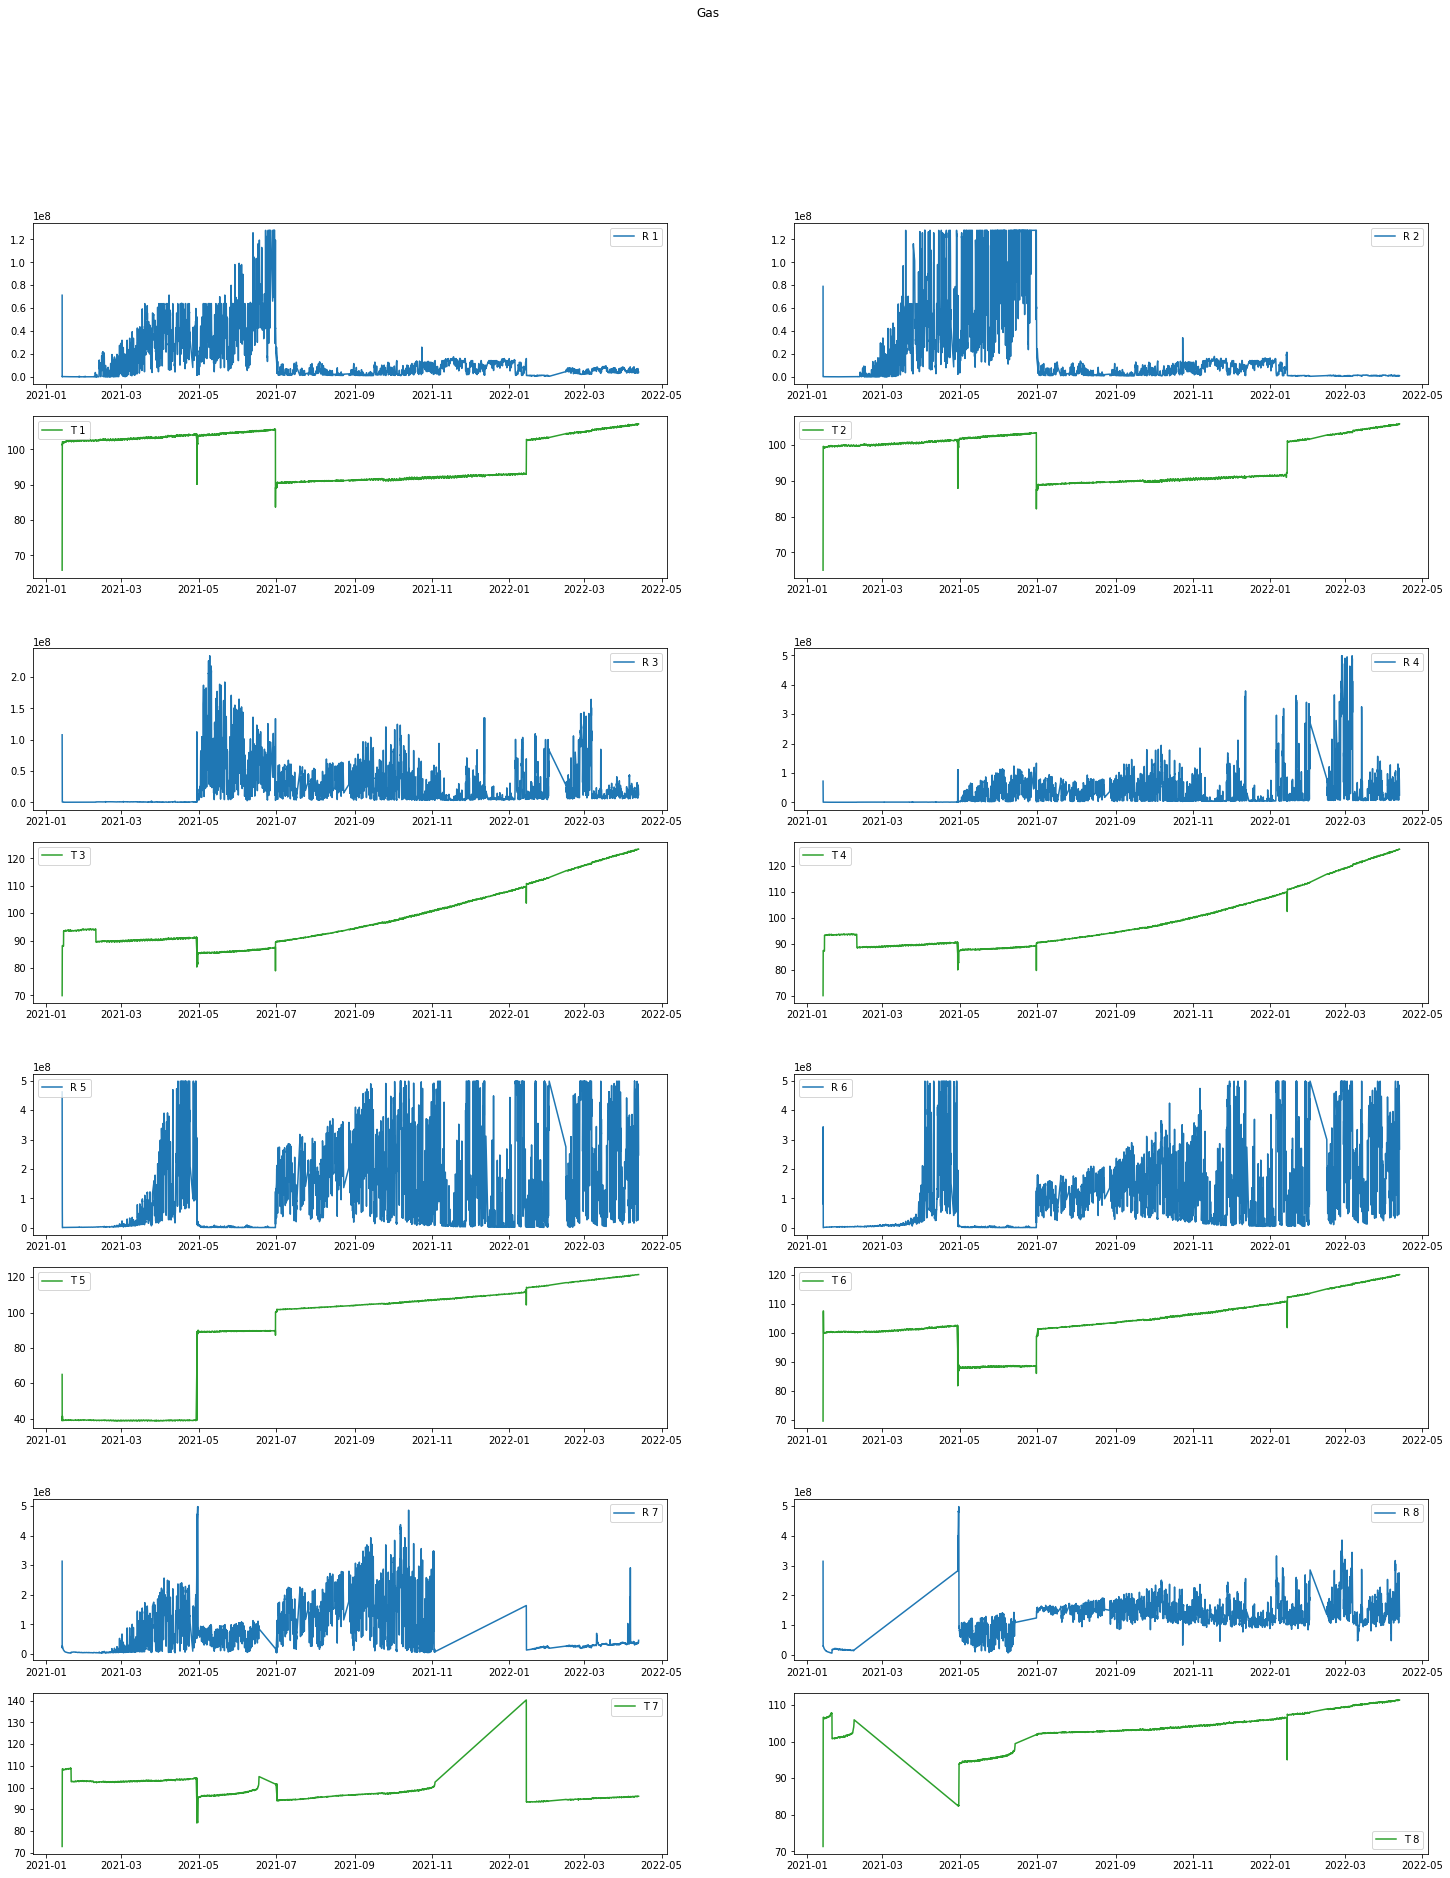

In [30]:
#This is really an important function as it can permit you to see the data in a more readable way. Notice that you can tweak
#all the dependence of the plot that I defined and used. The dataset that you see is already filtered as I added the provision
# df8["T" + str(i)] < 160, this is because if you have the resistance of the Heater over 200 Ohm the single sensor is broken.
#You can check this intuition just by taking out that provision and see what else you can notice, maybe taking about other problem
#about sensor signal and sensor replacements

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(25, 30))
fig.suptitle('Gas')
outer = gridspec.GridSpec(4,2, wspace=0.2, hspace=0.2)
cl=df8.columns
annostr = ["R","T"]
gas=["PM10","Biossido di Azoto","Ozono","Biossido Zolfo"]
color=["blue","green"]
count = 0
for i in range(1,9):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i-1], wspace=0.1, hspace=0.2)

    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        ax.plot(df8.loc[df8["T" + str(i)] < 160][:].index, df8.loc[df8["T" + str(i)] < 160][:][annostr[j]+str(i)],'tab:'+color[j], label=annostr[j]+" "+str(i))
        ax.legend()
        fig.add_subplot(ax)
#fig.savefig('APPA1-2021-22.png', dpi=600, bbox_inches='tight')
fig.show()

# A Little detailed example on how to visualize data

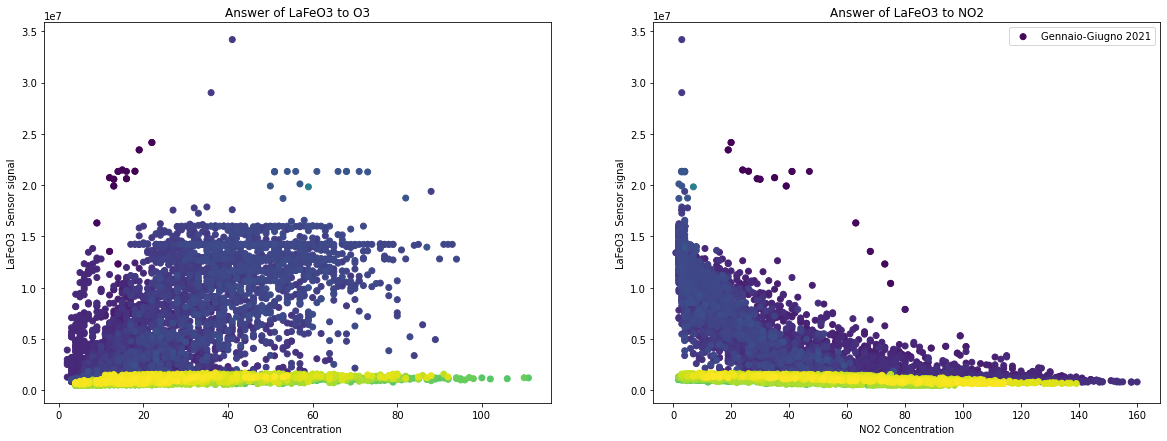

In [31]:
#This is an example of how to perform some data visualization. Take note that plotly is probably way better to do the exact same
#thing but I learned about its existance this morning so I need to make myself accustomed to it.

#For now I will just teach you the basic of to make plots with matplotlib, in general if you have question, ask me or ask google
#The second one knows more things usually 
#You are defining the "Canvas" or the space where you are drawing the plots
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
#Definition of the two plots, notice that you can add a third dimension through the use of the color of the points,
#Again plotly actually seems to do the job in a better way, you can tweak the variable to see if you can notice something
ax1.scatter(df8["07/01/2021":]["Biossido di Azoto"], df8["07/01/2021":].R2, c =  df8["07/01/2021":].T2,label='Gennaio-Giugno 2021')
ax2.scatter(df8["07/01/2021":]["Ozono"], df8["07/01/2021":].R2, c =  df8["07/01/2021":].T2,label='Gennaio-Giugno 2021')

#Legends, title and title axes of the two graph
ax2.set_title('Answer of LaFeO3 to NO2')
ax2.set_xlabel('NO2 Concentration')
ax2.set_ylabel('LaFeO3  Sensor signal')
ax1.set_title('Answer of LaFeO3 to O3')
ax1.set_xlabel('O3 Concentration')
ax1.set_ylabel('LaFeO3  Sensor signal')
#You can in general: set a limit to each axis, add text, save the figure, use a logaritmic scale either on the X or the Y, just try and see what works or not
#ax2.set_ylim((0,0.2*10**8))
#ax2.text(0.02, 0.86, "$\mathregular{R^2}$ = " + str(round(r_squared,3)) + "  RMS  = "  + str(round(rms,3))+ " ppb", transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.legend()
#plt.savefig('PM10allRPredict.png', dpi=600, bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


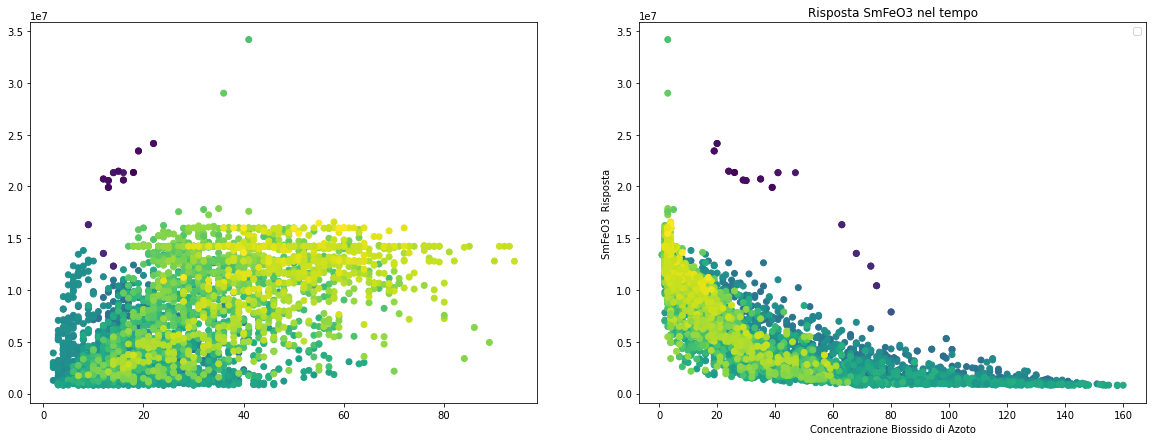

In [32]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
ax1.scatter(df8["07/01/2021":"12/31/2021"]["Biossido di Azoto"], df8["07/01/2021":"12/31/2021"].R2, c = df8["07/01/2021":"12/31/2021"].T2)
ax2.scatter(df8["07/01/2021":"12/31/2021"]["Ozono"], df8["07/01/2021":"12/31/2021"].R2, c = df8["07/01/2021":"12/31/2021"].T2)
ax2.set_title('Risposta SmFeO3 nel tempo')
ax2.set_xlabel('Concentrazione Biossido di Azoto')
ax2.set_ylabel('SmFeO3  Risposta')
#ax2.set_ylim((0,6400000)) 
#ax2.set_ylim((0,7500000)) TEMP
#ax2.set_ylim((0.075*10**8,0.16*10**8))
#ax2.text(0.02, 0.86, "$\mathregular{R^2}$ = " + str(round(r_squared,3)) + "  RMS  = "  + str(round(rms,3))+ " ppb", transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.legend()
#plt.savefig('PM10allRPredict.png', dpi=600, bbox_inches='tight')
plt.show()

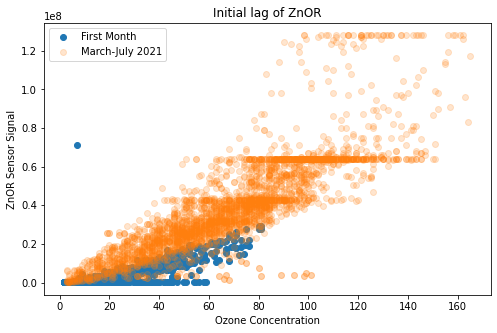

In [33]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(8,5))
ax2 = fig.add_subplot()
#ax = ax2.twinx()
ax2.scatter(df8[:"02/28/2021"].Ozono, df8[:"02/28/2021"].R1, label='First Month')
ax2.scatter(df8["02/28/2021":"07/01/2021"].Ozono, df8["02/28/2021":"07/01/2021"].R1, alpha = 0.2, label='March-July 2021')
ax2.set_title('Initial lag of ZnOR')
ax2.set_xlabel('Ozone Concentration')
ax2.set_ylabel('ZnOR Sensor Signal')
ax2.legend()
plt.show()

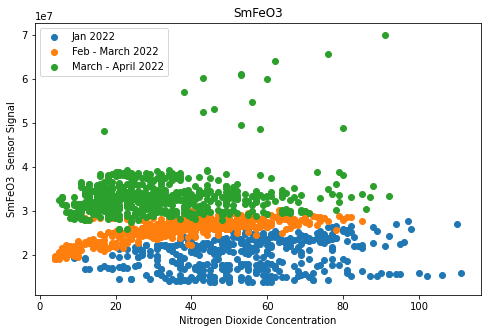

In [34]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(8,5))
ax2 = fig.add_subplot()
ax2.scatter(df8["01/15/2022":"02/15/2022"]["Biossido di Azoto"], df8["01/15/2022":"02/15/2022"].R7, label='Jan 2022')
ax2.scatter(df8["02/15/2022":"03/08/2022"]["Biossido di Azoto"], df8["02/15/2022":"03/08/2022"].R7, label='Feb - March 2022')
ax2.scatter(df8["03/08/2022":"04/03/2022"]["Biossido di Azoto"], df8["03/08/2022":"04/03/2022"].R7, label='March - April 2022')
ax2.set_title('SmFeO3')
ax2.set_xlabel('Nitrogen Dioxide Concentration')
ax2.set_ylabel('SmFeO3  Sensor Signal')
ax2.legend()
plt.show()

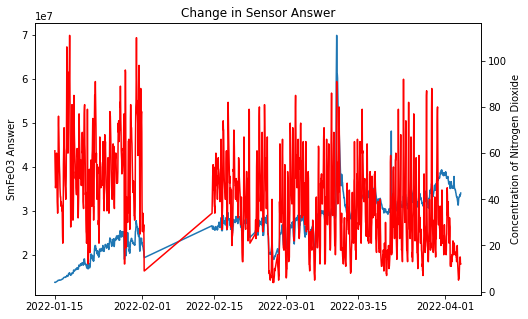

In [35]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(8,5))
ax2 = fig.add_subplot()
ax = ax2.twinx()
ax2.plot(df8["01/15/2022":"04/03/2022"].index, df8["01/15/2022":"04/03/2022"].R7)
ax.plot(df8["01/15/2022":"04/03/2022"].index, df8["01/15/2022":"04/03/2022"]["Biossido di Azoto"], c="r" )
ax2.set_title('Change in Sensor Answer')
ax2.set_ylabel('SmFeO3 Answer')
ax.set_ylabel('Concentration of Nitrogen Dioxide')
plt.show()

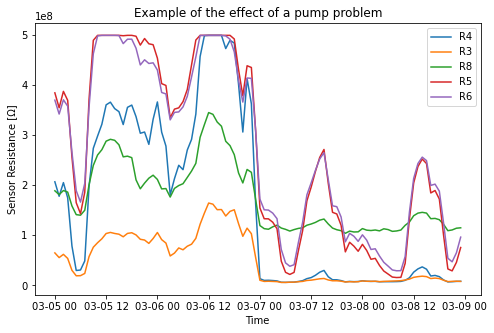

In [36]:
#Here you can see a pump fail in good detail, can you find something similar in the full data, or other "funny" things_

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(8,5))
ax2 = fig.add_subplot()
ax2.plot(df8["03/05/2022":"03/08/2022"].index, df8["03/05/2022":"03/08/2022"].R4, label = "R4")
ax2.plot(df8["03/05/2022":"03/08/2022"].index, df8["03/05/2022":"03/08/2022"].R3, label = "R3")
ax2.plot(df8["03/05/2022":"03/08/2022"].index, df8["03/05/2022":"03/08/2022"].R8, label = "R8")
ax2.plot(df8["03/05/2022":"03/08/2022"].index, df8["03/05/2022":"03/08/2022"].R5, label = "R5")
ax2.plot(df8["03/05/2022":"03/08/2022"].index, df8["03/05/2022":"03/08/2022"].R6, label = "R6")
ax2.set_title('Example of the effect of a pump problem')
ax2.set_ylabel('Sensor Resistance [Ω]')
ax2.set_xlabel('Time')
ax2.legend()
plt.show()

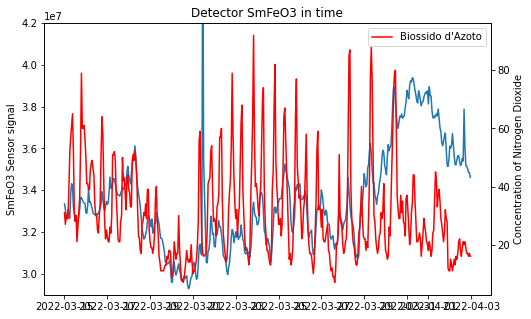

In [37]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(8,5))
ax2 = fig.add_subplot()
ax = ax2.twinx()
ax2.plot(df8["03/15/2022":"04/02/2022"].index, df8["03/15/2022":"04/02/2022"].R7)
ax.plot(df8["03/15/2022":"04/02/2022"].index, df8["03/15/2022":"04/02/2022"]["Biossido di Azoto"], c="r", label = "Biossido d'Azoto" )
ax2.set_title('Detector SmFeO3 in time')
ax2.set_ylabel('SmFeO3 Sensor signal')
ax.set_ylabel('Concentration of Nitrogen Dioxide')
ax2.set_ylim((2.9*10**7,4.2*10**7))
ax.legend()
plt.show()

# Samario Ferro

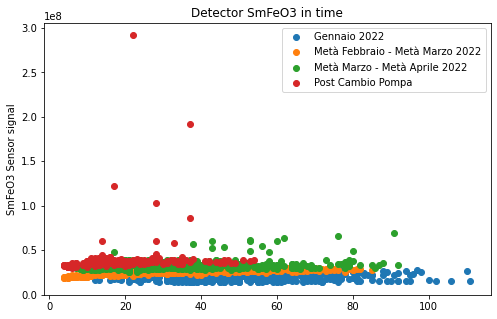

In [38]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(8,5))
ax2 = fig.add_subplot()
ax2.scatter(df8["01/15/2022":"02/15/2022"]["Biossido di Azoto"], df8["01/15/2022":"02/15/2022"].R7, label='Gennaio 2022')
ax2.scatter(df8["02/15/2022":"03/08/2022"]["Biossido di Azoto"], df8["02/15/2022":"03/08/2022"].R7, label='Metà Febbraio - Metà Marzo 2022')
ax2.scatter(df8["03/08/2022":"04/03/2022"]["Biossido di Azoto"], df8["03/08/2022":"04/03/2022"].R7, label='Metà Marzo - Metà Aprile 2022')
ax2.scatter(df8["04/03/2022":]["Biossido di Azoto"], df8["04/03/2022":].R7, label='Post Cambio Pompa')
ax2.set_title('Detector SmFeO3 in time')
ax2.set_ylabel('SmFeO3 Sensor signal')
ax.set_ylabel('Concentration of Nitrogen Dioxide')
ax2.legend()
plt.show()

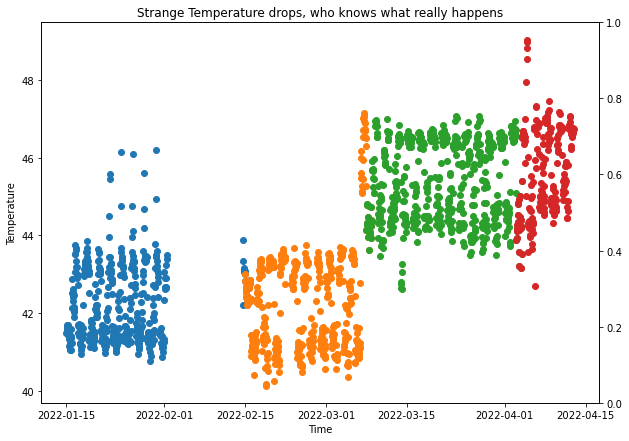

In [39]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
ax = ax2.twinx()
ax2.scatter(df8["01/15/2022":"02/15/2022"].index, df8["01/15/2022":"02/15/2022"].TEMP)
ax2.scatter(df8["02/15/2022":"03/08/2022"].index, df8["02/15/2022":"03/08/2022"].TEMP)
ax2.scatter(df8["03/08/2022":"04/03/2022"].index, df8["03/08/2022":"04/03/2022"].TEMP)
ax2.scatter(df8["04/03/2022":].index, df8["04/03/2022":].TEMP)

ax2.set_title('Strange Temperature drops, who knows what really happens')
ax2.set_xlabel('Time')
ax2.set_ylabel('Temperature')
plt.show()

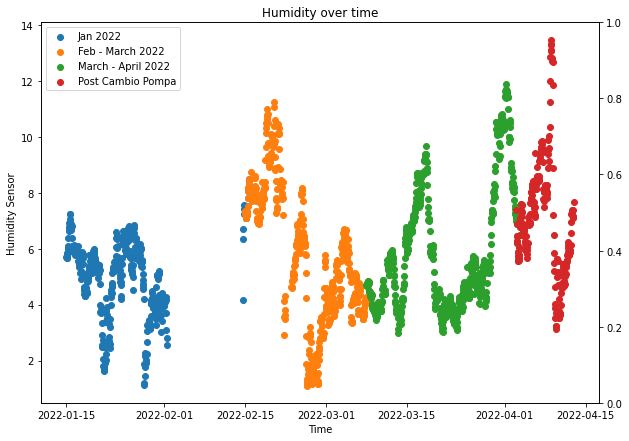

In [40]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
ax = ax2.twinx()
ax2.scatter(df8["01/15/2022":"02/15/2022"].index, df8["01/15/2022":"02/15/2022"].HUM, label='Jan 2022')
ax2.scatter(df8["02/15/2022":"03/08/2022"].index, df8["02/15/2022":"03/08/2022"].HUM, label='Feb - March 2022')
ax2.scatter(df8["03/08/2022":"04/03/2022"].index, df8["03/08/2022":"04/03/2022"].HUM, label='March - April 2022')
ax2.scatter(df8["04/03/2022":].index, df8["04/03/2022":].HUM, label='Post Cambio Pompa')

ax2.set_title('Humidity over time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Humidity Sensor')
ax2.legend()
plt.show()

In [41]:
corrcomplete1 = df8["02/15/2022":"03/09/2022"].corr()

corrcomplete1.style.background_gradient(cmap='coolwarm')

In [42]:
corrcomplete2 = df10.corr()

corrcomplete2.style.background_gradient(cmap='coolwarm')

Real naive example of a machine learning process, name all the error that are made in it.

In [53]:
#Real Machine Learning part, split the data and the object

X = df8.drop('Ozono', axis = 1)
X = X.drop('Biossido Zolfo', axis = 1)
X = X.drop('PM10', axis = 1)
X = X.drop('Biossido di Azoto', axis = 1)
X = X.drop('Ossido di Carbonio', axis = 1)

y = df8[['Ozono','Biossido Zolfo','PM10','Biossido di Azoto','Ossido di Carbonio']].copy()

INPUT_DIM = 18

In [54]:
#I just called the test validation set, but I promis you that it will make someday sense
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 20)

In [55]:
#Scale data, otherwise model will fail.
#Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

scaler=StandardScaler()
scaler.fit(y_train)

y_train_s = scaler.transform(y_train)
y_val_s = pd.DataFrame(data = scaler.transform(y_val), columns = y_val.columns)

In [56]:
# define the model
#Experiment with deeper and wider networks
model = Sequential()

# Input layer

model.add(Dense(128, kernel_initializer='normal',input_dim=INPUT_DIM, activation='selu'))
model.add(Dropout(0.2))


# The Hidden Layers :
model.add(Dense(256, kernel_initializer='normal',activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(256, kernel_initializer='normal',activation='selu'))
model.add(Dropout(0.2))

model.add(Dense(256, kernel_initializer='normal',activation='selu'))
model.add(Dropout(0.2))

#Output layer
model.add(Dense(5, kernel_initializer='normal',activation='linear'))

model.compile(loss=a2, optimizer='adam', metrics=[a2])
model.summary()

checkpoint_name = './tmp/checkpoint' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='min')
callbacks_list = [checkpoint]

history = model.fit(X_train_scaled, y_train_s, validation_split=0.2, epochs=300,callbacks=[checkpoint])
model.load_weights(checkpoint_name)
#wights_file = 'Weights-478--18738.19831.hdf5' # choose the best checkpoint 
# # load it
#model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               2432      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

Epoch 28/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3922 - mean_squared_error: 0.3922 - val_loss: 0.3306 - val_mean_squared_error: 0.3306

Epoch 00028: val_loss did not improve from 0.32116
Epoch 29/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3937 - mean_squared_error: 0.3937 - val_loss: 0.3240 - val_mean_squared_error: 0.3240

Epoch 00029: val_loss did not improve from 0.32116
Epoch 30/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3854 - mean_squared_error: 0.3854 - val_loss: 0.3170 - val_mean_squared_error: 0.3170

Epoch 00030: val_loss improved from 0.32116 to 0.31700, saving model to ./tmp\checkpoint
INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets
Epoch 31/300
175/175 [==============================] - 0s 3ms/step - loss: 0.3796 - mean_squared_error: 0.3796 - val_loss: 0.3287 - val_mean_squared_error: 0.3287

Epoch 00031: val_loss did not improve from 0.31700
Epoch 32/300
175/175 [=================

175/175 [==============================] - 1s 3ms/step - loss: 0.3620 - mean_squared_error: 0.3620 - val_loss: 0.2958 - val_mean_squared_error: 0.2958

Epoch 00063: val_loss did not improve from 0.29166
Epoch 64/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3517 - mean_squared_error: 0.3517 - val_loss: 0.3157 - val_mean_squared_error: 0.3157

Epoch 00064: val_loss did not improve from 0.29166
Epoch 65/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3581 - mean_squared_error: 0.3581 - val_loss: 0.2877 - val_mean_squared_error: 0.2877

Epoch 00065: val_loss improved from 0.29166 to 0.28773, saving model to ./tmp\checkpoint
INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets
Epoch 66/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3488 - mean_squared_error: 0.3488 - val_loss: 0.2856 - val_mean_squared_error: 0.2856

Epoch 00066: val_loss improved from 0.28773 to 0.28564, saving model to ./tmp\checkpoint
INFO:tensorflo

175/175 [==============================] - 1s 3ms/step - loss: 0.3398 - mean_squared_error: 0.3398 - val_loss: 0.2757 - val_mean_squared_error: 0.2757

Epoch 00098: val_loss did not improve from 0.27157
Epoch 99/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3378 - mean_squared_error: 0.3378 - val_loss: 0.2827 - val_mean_squared_error: 0.2827

Epoch 00099: val_loss did not improve from 0.27157
Epoch 100/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3375 - mean_squared_error: 0.3375 - val_loss: 0.3064 - val_mean_squared_error: 0.3064

Epoch 00100: val_loss did not improve from 0.27157
Epoch 101/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3394 - mean_squared_error: 0.3394 - val_loss: 0.2840 - val_mean_squared_error: 0.2840

Epoch 00101: val_loss did not improve from 0.27157
Epoch 102/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3403 - mean_squared_error: 0.3403 - val_loss: 0.2800 - val_mean_squa

175/175 [==============================] - 1s 3ms/step - loss: 0.3325 - mean_squared_error: 0.3325 - val_loss: 0.2737 - val_mean_squared_error: 0.2737

Epoch 00135: val_loss did not improve from 0.26974
Epoch 136/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3269 - mean_squared_error: 0.3269 - val_loss: 0.2955 - val_mean_squared_error: 0.2955

Epoch 00136: val_loss did not improve from 0.26974
Epoch 137/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3260 - mean_squared_error: 0.3260 - val_loss: 0.2721 - val_mean_squared_error: 0.2721

Epoch 00137: val_loss did not improve from 0.26974
Epoch 138/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3258 - mean_squared_error: 0.3258 - val_loss: 0.2792 - val_mean_squared_error: 0.2792

Epoch 00138: val_loss did not improve from 0.26974
Epoch 139/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3315 - mean_squared_error: 0.3315 - val_loss: 0.2629 - val_mean_squ

175/175 [==============================] - 1s 3ms/step - loss: 0.3224 - mean_squared_error: 0.3224 - val_loss: 0.2651 - val_mean_squared_error: 0.2651

Epoch 00172: val_loss did not improve from 0.25428
Epoch 173/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3239 - mean_squared_error: 0.3239 - val_loss: 0.2730 - val_mean_squared_error: 0.2730

Epoch 00173: val_loss did not improve from 0.25428
Epoch 174/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3165 - mean_squared_error: 0.3165 - val_loss: 0.2617 - val_mean_squared_error: 0.2617

Epoch 00174: val_loss did not improve from 0.25428
Epoch 175/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3148 - mean_squared_error: 0.3148 - val_loss: 0.2757 - val_mean_squared_error: 0.2757

Epoch 00175: val_loss did not improve from 0.25428
Epoch 176/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3174 - mean_squared_error: 0.3174 - val_loss: 0.2841 - val_mean_squ

175/175 [==============================] - 1s 3ms/step - loss: 0.3157 - mean_squared_error: 0.3157 - val_loss: 0.2800 - val_mean_squared_error: 0.2800

Epoch 00210: val_loss did not improve from 0.25428
Epoch 211/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3174 - mean_squared_error: 0.3174 - val_loss: 0.2550 - val_mean_squared_error: 0.2550

Epoch 00211: val_loss did not improve from 0.25428
Epoch 212/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3128 - mean_squared_error: 0.3128 - val_loss: 0.2990 - val_mean_squared_error: 0.2990

Epoch 00212: val_loss did not improve from 0.25428
Epoch 213/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3130 - mean_squared_error: 0.3130 - val_loss: 0.2697 - val_mean_squared_error: 0.2697

Epoch 00213: val_loss did not improve from 0.25428
Epoch 214/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3156 - mean_squared_error: 0.3156 - val_loss: 0.2726 - val_mean_squ

Epoch 247/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3099 - mean_squared_error: 0.3099 - val_loss: 0.2721 - val_mean_squared_error: 0.2721

Epoch 00247: val_loss did not improve from 0.24493
Epoch 248/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3078 - mean_squared_error: 0.3078 - val_loss: 0.2729 - val_mean_squared_error: 0.2729

Epoch 00248: val_loss did not improve from 0.24493
Epoch 249/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3083 - mean_squared_error: 0.3083 - val_loss: 0.2965 - val_mean_squared_error: 0.2965

Epoch 00249: val_loss did not improve from 0.24493
Epoch 250/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3078 - mean_squared_error: 0.3078 - val_loss: 0.2696 - val_mean_squared_error: 0.2696

Epoch 00250: val_loss did not improve from 0.24493
Epoch 251/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3131 - mean_squared_error: 0.3131 - val_loss: 0.2537 


Epoch 00284: val_loss improved from 0.24493 to 0.24424, saving model to ./tmp\checkpoint
INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets
Epoch 285/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3041 - mean_squared_error: 0.3041 - val_loss: 0.2576 - val_mean_squared_error: 0.2576

Epoch 00285: val_loss did not improve from 0.24424
Epoch 286/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3018 - mean_squared_error: 0.3018 - val_loss: 0.2584 - val_mean_squared_error: 0.2584

Epoch 00286: val_loss did not improve from 0.24424
Epoch 287/300
175/175 [==============================] - 1s 3ms/step - loss: 0.3098 - mean_squared_error: 0.3098 - val_loss: 0.2647 - val_mean_squared_error: 0.2647

Epoch 00287: val_loss did not improve from 0.24424
Epoch 288/300
175/175 [==============================] - 1s 3ms/step - loss: 0.2993 - mean_squared_error: 0.2993 - val_loss: 0.2692 - val_mean_squared_error: 0.2692

Epoch 00288: val_loss did not impr

## Prediction on test

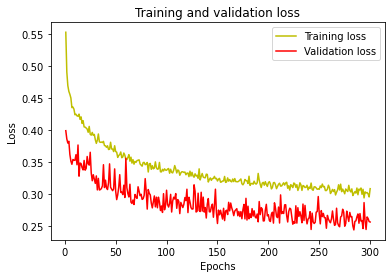

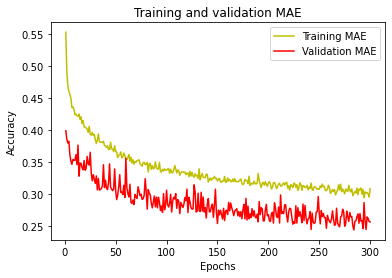

Predicted values are:  [[18.998413    1.6244243  12.428109   33.96059     0.96850675]
 [64.04956     1.4082878  14.1370535  24.772625    0.73950607]
 [16.50076     1.9896268  17.574049   45.363083    1.1239457 ]
 ...
 [11.599332    3.2404604  59.90677    67.012985    1.0012184 ]
 [ 4.5658236   1.90006    16.074314   30.661482    1.0148065 ]
 [-1.0006782   4.8525205  28.31492    61.094013    1.628837  ]]
Real values are:                       Ozono  Biossido Zolfo  PM10  Biossido di Azoto  \
Time                                                                  
2021-11-04 18:00:00   10.0             1.0   5.0               53.0   
2021-04-20 10:00:00   60.0             2.0   9.0               21.0   
2022-03-02 08:00:00   14.0             3.0  25.0               57.0   
2022-01-22 05:00:00   15.0             1.0  14.0               47.0   
2021-08-13 19:00:00  123.0             2.0  28.0               21.0   
...                    ...             ...   ...                ...   
2021-01

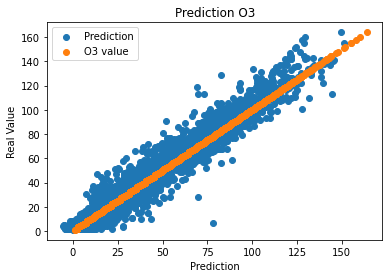

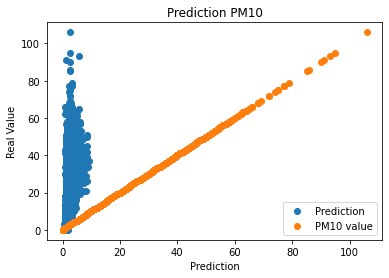

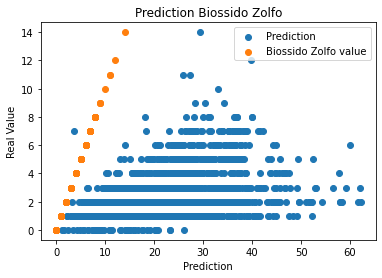

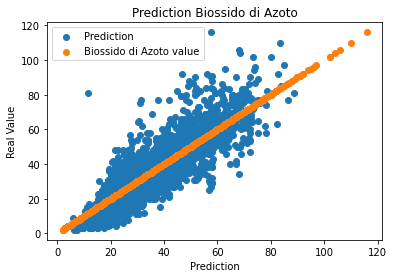

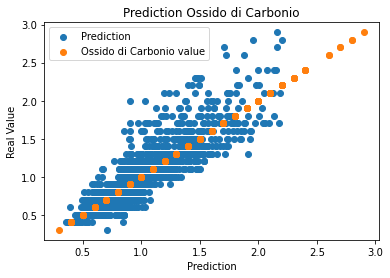

In [57]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['mean_squared_error']
val_acc = history.history['val_mean_squared_error']
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

############################################
#Predict on test data
predictions = model.predict(X_val_scaled)

predictions = scaler.inverse_transform(predictions)

y_val_ssaved = y_val_s
y_val_s = y_val
print("Predicted values are: ", predictions)
print("Real values are: ", y_val_s)

##############################################
#Plot and compare prediction and real value
t = np.arange(0, predictions.size, 1)
plt.scatter(predictions[:,0], y_val_s["Ozono"], label='Prediction')
plt.scatter(y_val_s["Ozono"], y_val_s["Ozono"], label='O3 value')
plt.title('Prediction O3')
plt.xlabel('Prediction')
plt.ylabel('Real Value')
plt.legend()
plt.savefig('Ozono.png', dpi=300, bbox_inches='tight')
plt.show()


t = np.arange(0, predictions.size, 1)
plt.scatter(predictions[:,1], y_val_s["PM10"], label='Prediction')
plt.scatter(y_val_s["PM10"], y_val_s["PM10"], label='PM10 value')
plt.title('Prediction PM10')
plt.xlabel('Prediction')
plt.ylabel('Real Value')
plt.legend()
plt.show()


t = np.arange(0, predictions.size, 1)
plt.scatter(predictions[:,2], y_val_s["Biossido Zolfo"], label='Prediction')
plt.scatter(y_val_s["Biossido Zolfo"], y_val_s["Biossido Zolfo"], label='Biossido Zolfo value')
plt.title('Prediction Biossido Zolfo')
plt.xlabel('Prediction')
plt.ylabel('Real Value')
plt.legend()
plt.show()


t = np.arange(0, predictions.size, 1)
plt.scatter(predictions[:,3], y_val_s["Biossido di Azoto"], label='Prediction')
plt.scatter(y_val_s["Biossido di Azoto"], y_val_s["Biossido di Azoto"], label='Biossido di Azoto value')
plt.title('Prediction Biossido di Azoto')
plt.xlabel('Prediction')
plt.ylabel('Real Value')
plt.legend()
plt.show()


t = np.arange(0, predictions.size, 1)
plt.scatter(predictions[:,4], y_val_s["Ossido di Carbonio"], label='Prediction')
plt.scatter(y_val_s["Ossido di Carbonio"], y_val_s["Ossido di Carbonio"], label='Ossido di Carbonio value')
plt.title('Prediction Ossido di Carbonio')
plt.xlabel('Prediction')
plt.ylabel('Real Value')
plt.legend()
plt.show()


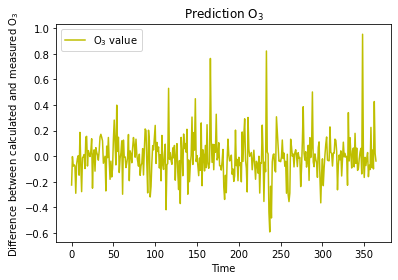

In [11]:
#From here on there is a lot a graph that I used to gain some information, I don't really want ot edit them until 3 AM, so I'm
#sorry if they are in english, you can just ignore them or try to take a look at them, I don't really know if they work anymore

supportografico = range(len(y_val_s) )
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico, y_val_s["Ossido di Carbonio"]-predictions[:,4], 'y', label='$\mathregular{O_3}$ value')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
plt.title('Prediction $\mathregular{O_3}$')
plt.xlabel('Time')
plt.ylabel('Difference between calculated and measured $\mathregular{O_3}$')
plt.legend()
plt.show()

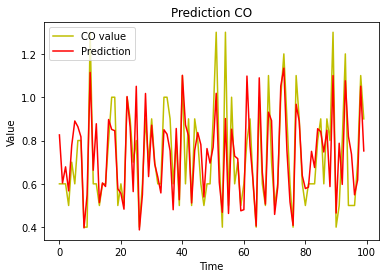

In [12]:
supportografico = range(0,100)
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico, y_val_s["Ossido di Carbonio"][:100], 'y', label='CO value')
plt.plot(supportografico, predictions[:100,4], 'r', label='Prediction')
plt.title('Prediction CO')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

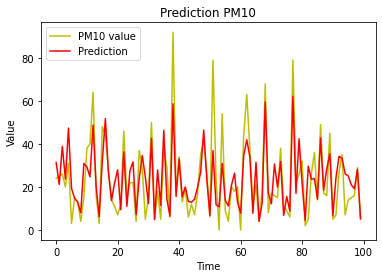

In [13]:
supportografico = range(0,100)
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico, y_val_s["PM10"][:100], 'y', label='PM10 value')
plt.plot(supportografico, predictions[:100,1], 'r', label='Prediction')
plt.title('Prediction PM10')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

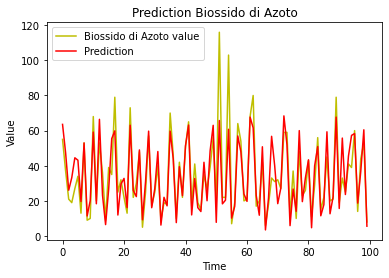

In [14]:
supportografico = range(0,100)
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico, y_val_s["Biossido di Azoto"][:100], 'y', label='Biossido di Azoto value')
plt.plot(supportografico, predictions[:100,3], 'r', label='Prediction')
plt.title('Prediction Biossido di Azoto')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [15]:
df8.head()

R1            R2            R3            R4            R5  \
9   7.131916e+07  7.902359e+07  1.078199e+08  7.204421e+07  4.624436e+08   
10  1.218931e+05  1.388258e+05  7.281900e+05  6.045887e+05  1.945371e+08   
11  1.666616e+05  1.725927e+05  6.107362e+05  5.313485e+05  2.733031e+08   
12  1.782083e+05  1.697632e+05  5.989559e+05  5.229369e+05  6.281952e+07   
13  6.142613e+05  1.656729e+05  5.967311e+05  5.181528e+05  1.773463e+07   

              R6            R7            R8          T1         T2  \
9   8.162741e+07  3.138289e+08  3.148292e+08   65.830769  65.038462   
10  2.202666e+08  2.043034e+07  3.140541e+07  101.164706  99.211765   
11  3.437187e+08  2.742710e+07  2.947224e+07  101.538333  99.500000   
12  3.228352e+07  2.781584e+07  3.047974e+07  101.556667  99.521667   
13  3.389715e+05  2.704933e+07  3.034089e+07  101.188333  99.570000   

           T3         T4         T5          T6          T7          T8  \
9   69.907692  70.092308  64.992308   69.500000   72.823077   71.323077   
10  87.739216  87.109804  38.782353  100.129412  108.049020  105.184314   
11  88.008333  87.396667  39.630000  102.476667  108.445000  106.568333   
12  88.051667  87.436667  41.295000  107.513333  108.525000  106.630000   
13  88.093333  87.468333  41.320000  107.570000  108.561667  106.668333   

     TEMP_BME       TEMP    HUM_BME        HUM  
9   23.184615  26.807692  25.553846  22.553846  
10  38.858824  41.113725  13.398039  11.288235  
11  43.971667  46.070000   6.635000   5.113333  
12  44.701667  46.823333   6.263333   4.701667  
13  45.615000  47.765000   6.041667   4.460000

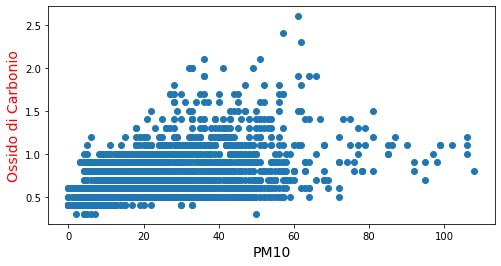

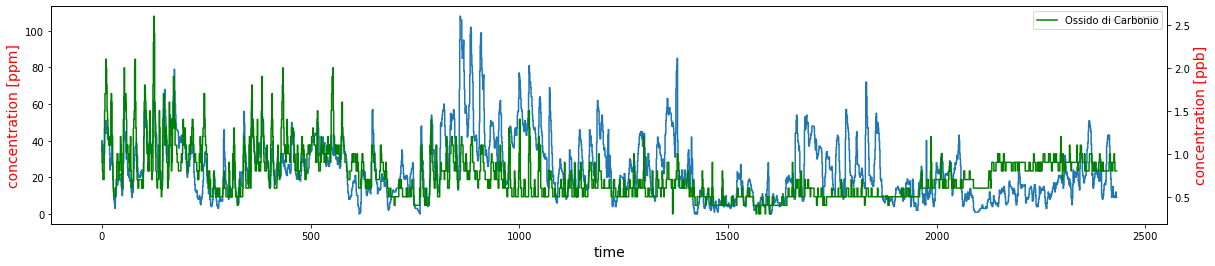

In [16]:

fig,ax = plt.subplots(figsize=(8,4))
ax.scatter(y["PM10"],y["Ossido di Carbonio"])
ax.set_xlabel("PM10",fontsize=14)
ax.set_ylabel("Ossido di Carbonio",color="red",fontsize=14)
plt.show()

support = range(len(y))
fig,ax = plt.subplots(figsize=(20,4))
ax.step(support,y["PM10"],label = "PM10" )
ax.set_xlabel("time",fontsize=14)
ax.set_ylabel("concentration [ppm]",color="red",fontsize=14)
ax2=ax.twinx()
ax2.step(support,y["Ossido di Carbonio"],color="green",label = "Ossido di Carbonio" )
ax2.set_ylabel("concentration [ppb]",color="red",fontsize=14)
ax.legend()
ax2.legend()

plt.show()

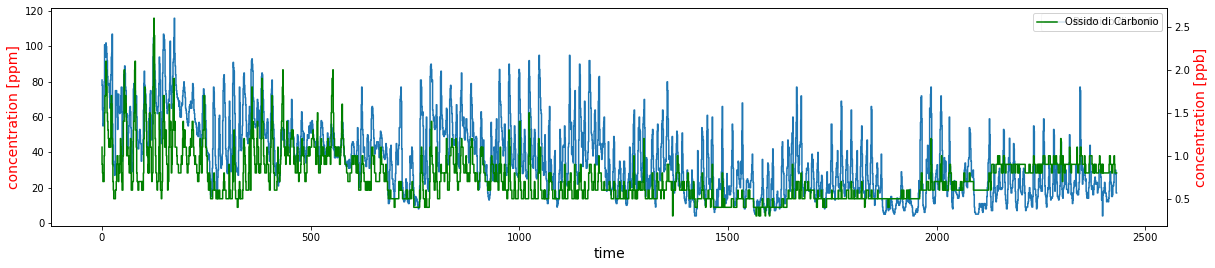

In [17]:
support = range(len(df8))
fig,ax = plt.subplots(figsize=(20,4))
ax.step(support,y["Biossido di Azoto"],label = "Biossido di Azoto" )
ax.set_xlabel("time",fontsize=14)
ax.set_ylabel("concentration [ppm]",color="red",fontsize=14)
ax2=ax.twinx()
ax2.step(support,y["Ossido di Carbonio"],color="green",label = "Ossido di Carbonio" )
ax2.set_ylabel("concentration [ppb]",color="red",fontsize=14)
ax.legend()
ax2.legend()

plt.show()

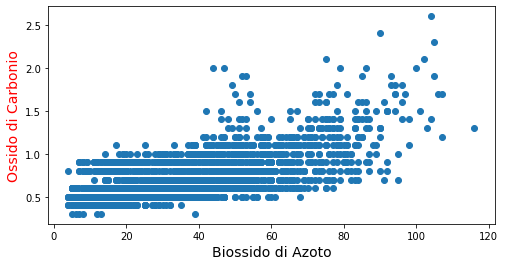

In [18]:
fig,ax = plt.subplots(figsize=(8,4))

ax.set_xlabel("Biossido di Azoto",fontsize=14)
ax.set_ylabel("Ossido di Carbonio",color="red",fontsize=14)

ax.scatter(y["Biossido di Azoto"],y["Ossido di Carbonio"])
plt.show()

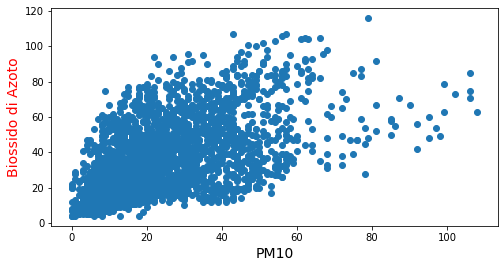

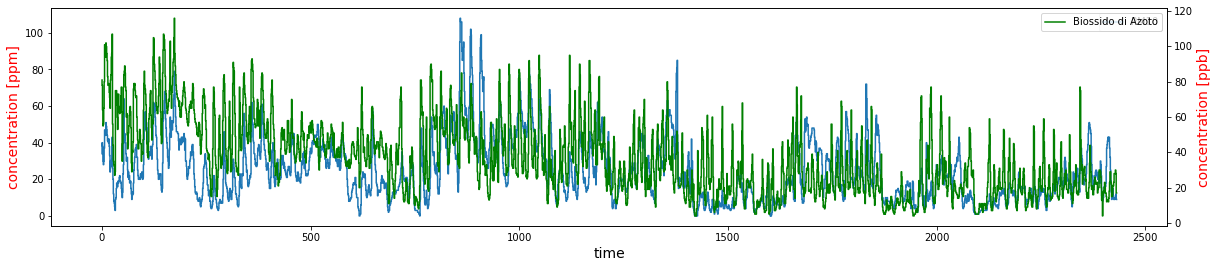

In [19]:
fig,ax = plt.subplots(figsize=(8,4))
ax.scatter(y["PM10"],y["Biossido di Azoto"])
ax.set_xlabel("PM10",fontsize=14)
ax.set_ylabel("Biossido di Azoto",color="red",fontsize=14)
plt.show()

support = range(len(y))
fig,ax = plt.subplots(figsize=(20,4))
ax.step(support,y["PM10"],label = "PM10" )
ax.set_xlabel("time",fontsize=14)
ax.set_ylabel("concentration [ppm]",color="red",fontsize=14)
ax2=ax.twinx()
ax2.step(support,y["Biossido di Azoto"],color="green",label = "Biossido di Azoto" )
ax2.set_ylabel("concentration [ppb]",color="red",fontsize=14)
ax.legend()
ax2.legend()

plt.show()

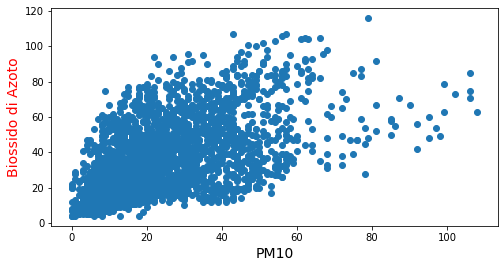

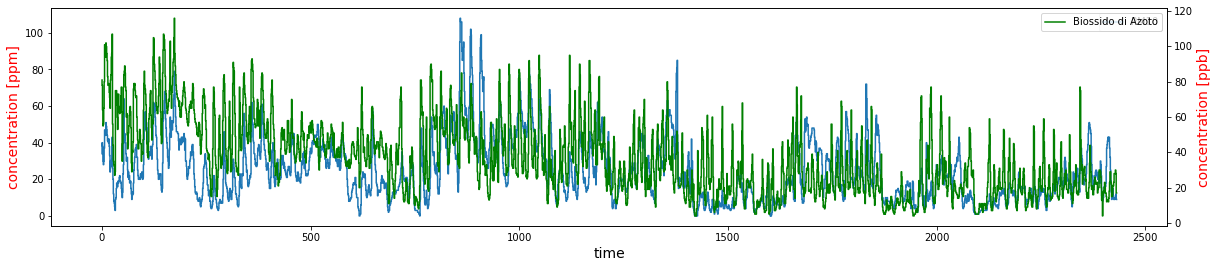

In [20]:
fig,ax = plt.subplots(figsize=(8,4))
ax.scatter(y["PM10"],y["Biossido di Azoto"])
ax.set_xlabel("PM10",fontsize=14)
ax.set_ylabel("Biossido di Azoto",color="red",fontsize=14)
plt.show()

support = range(len(y))
fig,ax = plt.subplots(figsize=(20,4))
ax.step(support,y["PM10"],label = "PM10" )
ax.set_xlabel("time",fontsize=14)
ax.set_ylabel("concentration [ppm]",color="red",fontsize=14)
ax2=ax.twinx()
ax2.step(support,y["Biossido di Azoto"],color="green",label = "Biossido di Azoto" )
ax2.set_ylabel("concentration [ppb]",color="red",fontsize=14)
ax.legend()
ax2.legend()

plt.show()


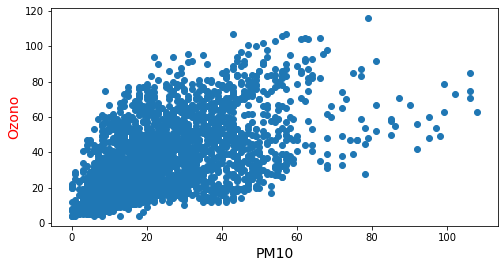

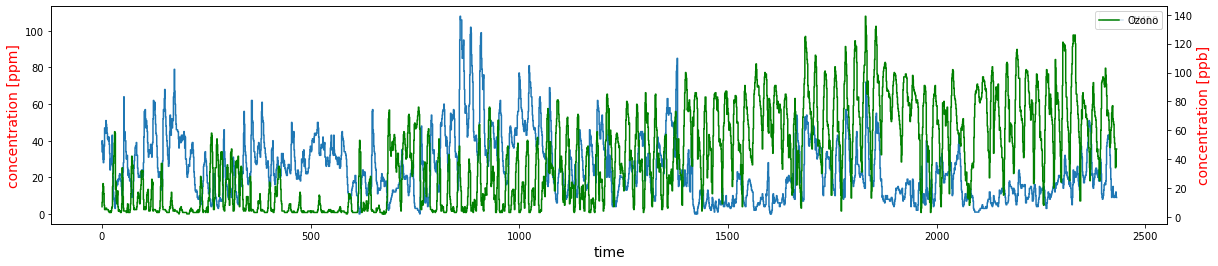

In [21]:
fig,ax = plt.subplots(figsize=(8,4))
ax.scatter(y["PM10"],y["Biossido di Azoto"])
ax.set_xlabel("PM10",fontsize=14)
ax.set_ylabel("Ozono",color="red",fontsize=14)
plt.show()

support = range(len(y))
fig,ax = plt.subplots(figsize=(20,4))
ax.step(support,y["PM10"],label = "PM10" )
ax.set_xlabel("time",fontsize=14)
ax.set_ylabel("concentration [ppm]",color="red",fontsize=14)
ax2=ax.twinx()
ax2.step(support,y["Ozono"],color="green",label = "Ozono" )
ax2.set_ylabel("concentration [ppb]",color="red",fontsize=14)
ax.legend()
ax2.legend()

plt.show()


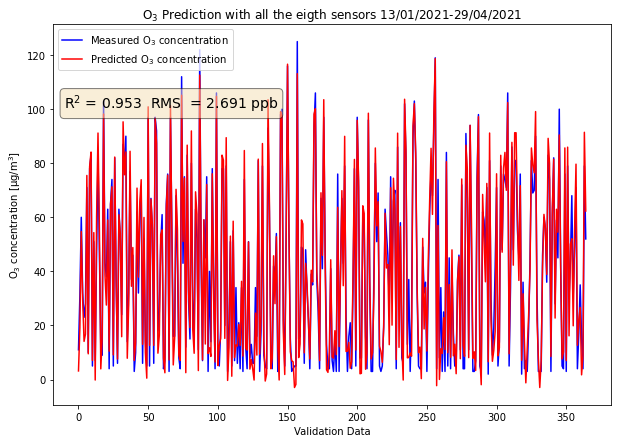

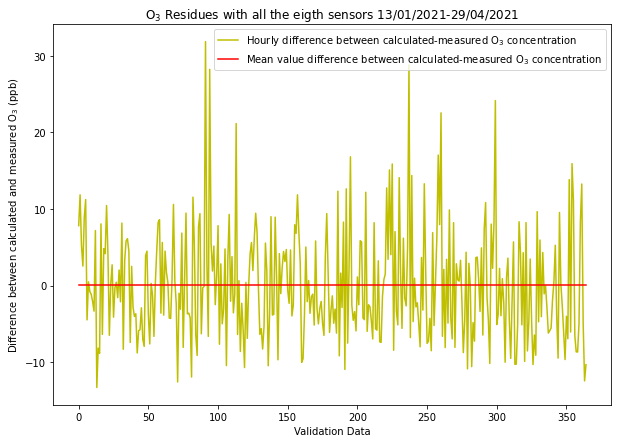

In [22]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_val_s["Ozono"].values.reshape(len(y_val_s["Ozono"]),1), predictions[:,0], squared=False)**0.5
correlation_matrix = np.corrcoef(y_val_s["Ozono"].values, predictions[:,0].T)

correlation_xy = correlation_matrix[0,1]

r_squared = correlation_xy**2


supportografico = range(len(y_val_s) )
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
t = np.arange(0, predictions.size, 1)
ax2.plot(supportografico, y_val_s["Ozono"], 'b', label='Measured $\mathregular{O_3}$ concentration')
ax2.plot(supportografico, predictions[:,0], 'r', label='Predicted $\mathregular{O_3}$ concentration')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
ax2.set_title('$\mathregular{O_3}$ Prediction with all the eigth sensors 13/01/2021-29/04/2021')
ax2.set_xlabel('Validation Data')
ax2.set_ylabel('$\mathregular{O_3}$ concentration [\u03BCg/$\mathregular{m^3}$]')
ax2.text(0.02, 0.82, "$\mathregular{R^2}$ = " + str(round(r_squared,3)) + "  RMS  = "  + str(round(rms,3))+ " ppb", transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.legend()
plt.savefig('O3allRPredict.png', dpi=600, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(10,7))
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico, y_val_s["Ozono"].values - predictions[:,0], 'y', label='Hourly difference between calculated-measured $\mathregular{O_3}$ concentration')
plt.plot(supportografico, [np.mean( y_val_s["Ozono"].values.reshape(len(y_val_s["Ozono"]),1) - predictions[:,0]) for i in range(len(y_val_s["Ozono"]) )], 'r', label='Mean value difference between calculated-measured $\mathregular{O_3}$ concentration')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
plt.title('$\mathregular{O_3}$ Residues with all the eigth sensors 13/01/2021-29/04/2021')
plt.xlabel('Validation Data')
plt.ylabel('Difference between calculated and measured $\mathregular{O_3}$ (ppb)')
plt.legend()
plt.savefig('O3allR.png', dpi=600, bbox_inches='tight')
plt.show()



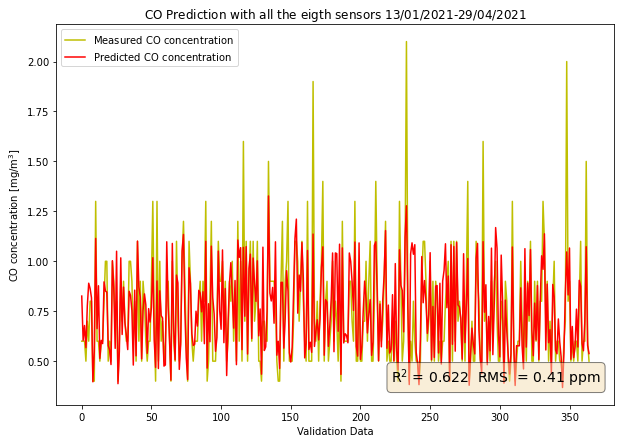

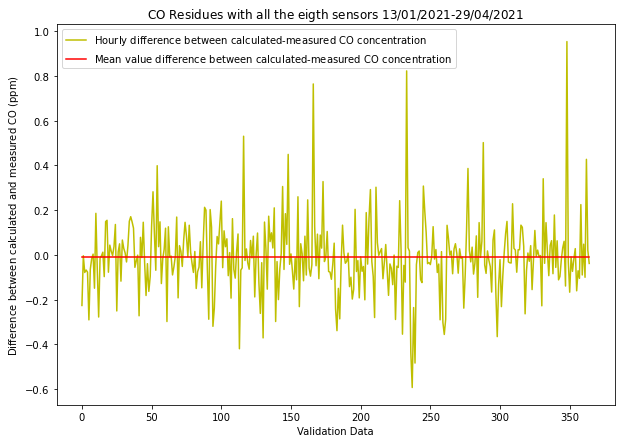

In [23]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_val_s["Ossido di Carbonio"].values.reshape(len(y_val_s["Ossido di Carbonio"]),1), predictions[:,4], squared=False)**0.5
correlation_matrix = np.corrcoef(y_val_s["Ossido di Carbonio"].values, predictions[:,4].T)

correlation_xy = correlation_matrix[0,1]

r_squared = correlation_xy**2


supportografico = range(len(y_val_s) )
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
t = np.arange(0, predictions.size, 1)
ax2.plot(supportografico, y_val_s["Ossido di Carbonio"], 'y', label='Measured $\mathregular{CO}$ concentration')
ax2.plot(supportografico, predictions[:,4], 'r', label='Predicted $\mathregular{CO}$ concentration')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
ax2.set_title('$\mathregular{CO}$ Prediction with all the eigth sensors 13/01/2021-29/04/2021')
ax2.set_xlabel('Validation Data')
ax2.set_ylabel('$\mathregular{CO}$ concentration [mg/$\mathregular{m^3}$]')
ax2.text(0.60, 0.10, "$\mathregular{R^2}$ = " + str(round(r_squared,3)) + "  RMS  = "  + str(round(rms,3))+ " ppm", transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.legend()
plt.savefig('COallRPredict.png', dpi=600, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(10,7))
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico, y_val_s["Ossido di Carbonio"].values - predictions[:,4], 'y', label='Hourly difference between calculated-measured $\mathregular{CO}$ concentration')
plt.plot(supportografico, [np.mean( y_val_s["Ossido di Carbonio"].values.reshape(len(y_val_s["Ossido di Carbonio"]),1) - predictions[:,4]) for i in range(len(y_val_s["Ossido di Carbonio"]) )], 'r', label='Mean value difference between calculated-measured $\mathregular{CO}$ concentration')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
plt.title('$\mathregular{CO}$ Residues with all the eigth sensors 13/01/2021-29/04/2021')
plt.xlabel('Validation Data')
plt.ylabel('Difference between calculated and measured $\mathregular{CO}$ (ppm)')
plt.legend()
plt.savefig('COallR.png', dpi=600, bbox_inches='tight')
plt.show()



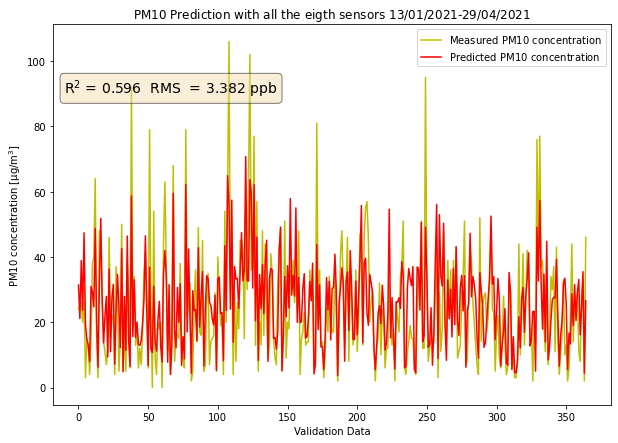

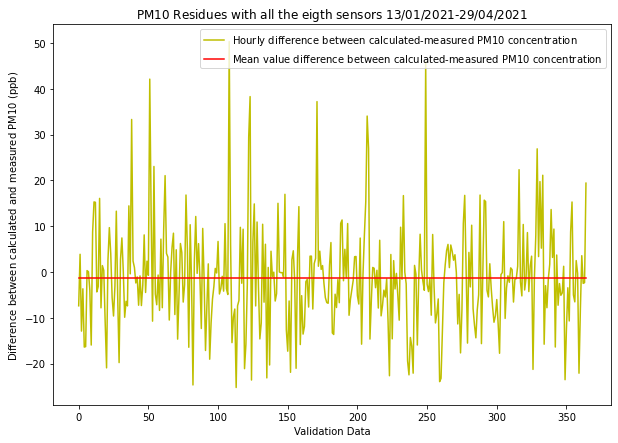

In [24]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_val_s["PM10"].values.reshape(len(y_val_s["PM10"]),1), predictions[:,1], squared=False)**0.5
correlation_matrix = np.corrcoef(y_val_s["PM10"].values, predictions[:,1].T)

correlation_xy = correlation_matrix[0,1]

r_squared = correlation_xy**2


supportografico = range(len(y_val_s) )
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
t = np.arange(0, predictions.size, 1)
ax2.plot(supportografico, y_val_s["PM10"], 'y', label='Measured $\mathregular{PM10}$ concentration')
ax2.plot(supportografico, predictions[:,1], 'r', label='Predicted $\mathregular{PM10}$ concentration')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
ax2.set_title('$\mathregular{PM10}$ Prediction with all the eigth sensors 13/01/2021-29/04/2021')
ax2.set_xlabel('Validation Data')
ax2.set_ylabel('$\mathregular{PM10}$ concentration [\u03BCg/$\mathregular{m^3}$]')
ax2.text(0.02, 0.86, "$\mathregular{R^2}$ = " + str(round(r_squared,3)) + "  RMS  = "  + str(round(rms,3))+ " ppb", transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.legend()
plt.savefig('PM10allRPredict.png', dpi=600, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(10,7))
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico, y_val_s["PM10"].values - predictions[:,1], 'y', label='Hourly difference between calculated-measured $\mathregular{PM10}$ concentration')
plt.plot(supportografico, [np.mean( y_val_s["PM10"].values.reshape(len(y_val_s["PM10"]),1) - predictions[:,1]) for i in range(len(y_val_s["PM10"]) )], 'r', label='Mean value difference between calculated-measured $\mathregular{PM10}$ concentration')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
plt.title('$\mathregular{PM10}$ Residues with all the eigth sensors 13/01/2021-29/04/2021')
plt.xlabel('Validation Data')
plt.ylabel('Difference between calculated and measured $\mathregular{PM10}$ (ppb)')
plt.legend()
plt.savefig('PM10allR.png', dpi=600, bbox_inches='tight')
plt.show()



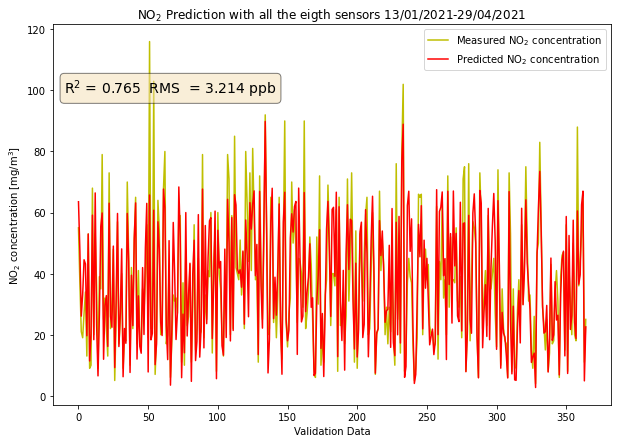

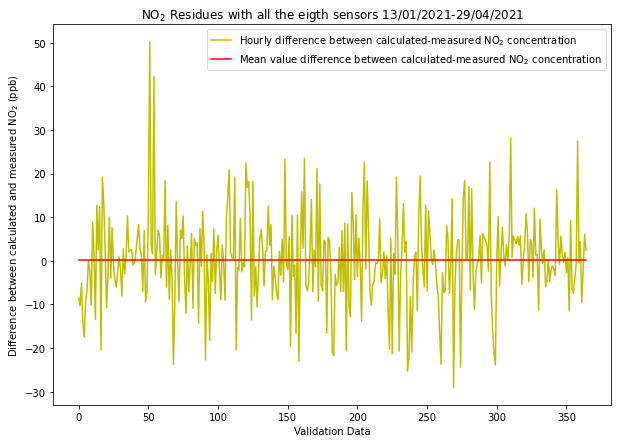

In [25]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_val_s["Biossido di Azoto"].values.reshape(len(y_val_s["Biossido di Azoto"]),1), predictions[:,3], squared=False)**0.5
correlation_matrix = np.corrcoef(y_val_s["Biossido di Azoto"].values, predictions[:,3].T)

correlation_xy = correlation_matrix[0,1]

r_squared = correlation_xy**2


supportografico = range(len(y_val_s) )
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
t = np.arange(0, predictions.size, 1)
ax2.plot(supportografico, y_val_s["Biossido di Azoto"], 'y', label='Measured $\mathregular{NO_2}$ concentration')
ax2.plot(supportografico, predictions[:,3], 'r', label='Predicted $\mathregular{NO_2}$ concentration')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
ax2.set_title('$\mathregular{NO_2}$ Prediction with all the eigth sensors 13/01/2021-29/04/2021')
ax2.set_xlabel('Validation Data')
ax2.set_ylabel('$\mathregular{NO_2}$ concentration [mg/$\mathregular{m^3}$]')
ax2.text(0.02, 0.86, "$\mathregular{R^2}$ = " + str(round(r_squared,3)) + "  RMS  = "  + str(round(rms,3))+ " ppb", transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax2.legend()
plt.savefig('NO_2allRPredict.png', dpi=600, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(10,7))
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico, y_val_s["Biossido di Azoto"].values - predictions[:,3], 'y', label='Hourly difference between calculated-measured $\mathregular{NO_2}$ concentration')
plt.plot(supportografico, [np.mean( y_val_s["Biossido di Azoto"].values.reshape(len(y_val_s["Biossido di Azoto"]),1) - predictions[:,3]) for i in range(len(y_val_s["PM10"]) )], 'r', label='Mean value difference between calculated-measured $\mathregular{NO_2}$ concentration')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
plt.title('$\mathregular{NO_2}$ Residues with all the eigth sensors 13/01/2021-29/04/2021')
plt.xlabel('Validation Data')
plt.ylabel('Difference between calculated and measured $\mathregular{NO_2}$ (ppb)')
plt.legend()
plt.savefig('NO_2allR.png', dpi=600, bbox_inches='tight')
plt.show()



In [26]:
corr = y.corr()

corr.style.background_gradient(cmap='coolwarm')

In [27]:
from pandas.plotting import table 

df9 = read_csv("29apr_1lug_appa1.csv",sep="\t",header=0)
df9 = df9.drop("Time",axis = 1)
df9 = df9.apply(pd.to_numeric, errors='coerce')
df9 = df9.dropna()
y2 = pd.DataFrame([df9.pop(i) for i in ["Ozono", "PM10","Biossido Zolfo", "Biossido di Azoto", "Ossido di Carbonio"]]).T



In [28]:
corr = y.corr()


corr.style.background_gradient(cmap='coolwarm')




In [29]:
corr2 = y2.corr()

corr2.style.background_gradient(cmap='coolwarm')

In [30]:
df11 = read_csv("1lug_22set_appa1.csv",sep="\t",header=0)
df11 = df11.drop("Time",axis = 1)
df11 = df11.apply(pd.to_numeric, errors='coerce')
df11 = df11.dropna()
y4 = pd.DataFrame([df11.pop(i) for i in ["Ozono", "PM10","Biossido Zolfo", "Biossido di Azoto", "Ossido di Carbonio"]]).T

corr4 = y4.corr()

corr4.style.background_gradient(cmap='coolwarm')

In [31]:


print(df8)

                R1            R2            R3            R4            R5  \
9     7.131916e+07  7.902359e+07  1.078199e+08  7.204421e+07  4.624436e+08   
10    1.218931e+05  1.388258e+05  7.281900e+05  6.045887e+05  1.945371e+08   
11    1.666616e+05  1.725927e+05  6.107362e+05  5.313485e+05  2.733031e+08   
12    1.782083e+05  1.697632e+05  5.989559e+05  5.229369e+05  6.281952e+07   
13    6.142613e+05  1.656729e+05  5.967311e+05  5.181528e+05  1.773463e+07   
...            ...           ...           ...           ...           ...   
2562  3.154827e+06  3.866846e+06  2.585224e+06  2.252611e+06  1.155901e+07   
2563  3.383900e+06  4.159279e+06  2.751506e+06  2.334740e+06  1.127265e+07   
2564  2.660721e+06  3.488866e+06  2.874168e+06  2.441202e+06  1.082136e+07   
2565  2.542060e+06  3.330329e+06  3.076428e+06  2.598593e+06  1.047149e+07   
2566  3.303117e+06  4.130461e+06  3.013671e+06  2.455530e+06  1.060186e+07   

                R6            R7            R8          T1     

In [60]:
prova15 = pd.merge(df8,df9,how = "outer")
prova16 = pd.merge(prova15,df11,how = "outer")
prova16

Time            R1            R2            R3  \
0     Jan 13 2021 09:00:00  7.131916e+07  7.902359e+07  1.078199e+08   
1     Jan 13 2021 10:00:00  1.218931e+05  1.388258e+05  7.281900e+05   
2     Jan 13 2021 11:00:00  1.666616e+05  1.725927e+05  6.107362e+05   
3     Jan 13 2021 12:00:00  1.782083e+05  1.697632e+05  5.989559e+05   
4     Jan 13 2021 13:00:00  6.142613e+05  1.656729e+05  5.967311e+05   
...                    ...           ...           ...           ...   
5572                   NaN  7.908322e+06  7.963747e+06  1.279946e+07   
5573                   NaN  6.403030e+06  6.476822e+06  1.827521e+07   
5574                   NaN  5.186537e+06  5.219521e+06  2.594370e+07   
5575                   NaN  3.808286e+06  3.745916e+06  3.864418e+07   
5576                   NaN  3.121951e+06  3.047619e+06  4.688645e+07   

                R4            R5            R6            R7            R8  \
0     7.204421e+07  4.624436e+08  8.162741e+07  3.138289e+08  3.148292e+08   
1     6.045887e+05  1.945371e+08  2.202666e+08  2.043034e+07  3.140541e+07   
2     5.313485e+05  2.733031e+08  3.437187e+08  2.742710e+07  2.947224e+07   
3     5.229369e+05  6.281952e+07  3.228352e+07  2.781584e+07  3.047974e+07   
4     5.181528e+05  1.773463e+07  3.389715e+05  2.704933e+07  3.034089e+07   
...            ...           ...           ...           ...           ...   
5572  1.533499e+07  1.291757e+08  1.178568e+08  1.185060e+08  1.391490e+08   
5573  2.549048e+07  1.766893e+08  1.458166e+08  1.472649e+08  1.472358e+08   
5574  3.839912e+07  2.216440e+08  1.698323e+08  1.760965e+08  1.565634e+08   
5575  5.808409e+07  2.871920e+08  2.035192e+08  2.214906e+08  1.739624e+08   
5576  6.994535e+07  3.273060e+08  2.247022e+08  2.523944e+08  1.810101e+08   

              T1  ...          T8   TEMP_BME       TEMP    HUM_BME        HUM  \
0      65.830769  ...   71.323077  23.184615  26.807692  25.553846  22.553846   
1     101.164706  ...  105.184314  38.858824  41.113725  13.398039  11.288235   
2     101.538333  ...  106.568333  43.971667  46.070000   6.635000   5.113333   
3     101.556667  ...  106.630000  44.701667  46.823333   6.263333   4.701667   
4     101.188333  ...  106.668333  45.615000  47.765000   6.041667   4.460000   
...          ...  ...         ...        ...        ...        ...        ...   
5572   91.733333  ...  103.440000   2.000000  43.690000  21.500000  14.826667   
5573   91.665000  ...  103.428333   2.000000  43.438333  21.500000  15.141667   
5574   91.730000  ...  103.418333   2.000000  43.386667  21.500000  15.340000   
5575   91.756140  ...  103.438596   2.000000  43.043860  21.500000  15.489474   
5576   91.733333  ...  103.500000   2.000000  43.100000  21.500000  14.950000   

      PM10  Biossido di Azoto  Ozono  Biossido Zolfo  Ossido di Carbonio  
0     34.0               81.0    7.0             7.0                 1.1  
1     40.0               78.0   10.0             7.0                 0.9  
2     38.0               64.0   17.0             5.0                 0.8  
3     30.0               55.0   23.0             5.0                 0.7  
4     28.0               56.0   21.0             5.0                 0.7  
...    ...                ...    ...             ...                 ...  
5572   NaN                NaN    NaN             NaN                 NaN  
5573   NaN                NaN    NaN             NaN                 NaN  
5574   NaN                NaN    NaN             NaN                 NaN  
5575   NaN                NaN    NaN             NaN                 NaN  
5576   NaN                NaN    NaN             NaN                 NaN  

[5577 rows x 26 columns]

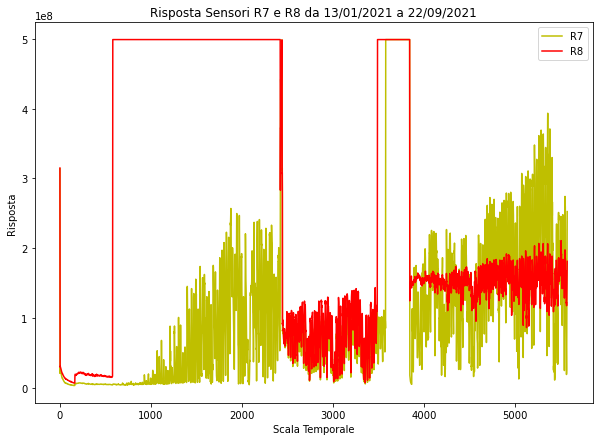

In [33]:
supportografico = range(len(prova16))

fig = plt.figure(figsize=(10,7))
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico,prova16.R7, 'y', label='R7')
plt.plot(supportografico, prova16.R8, 'r', label='R8')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
plt.title('Risposta Sensori R7 e R8 da 13/01/2021 a 22/09/2021')
plt.xlabel('Scala Temporale')
plt.ylabel('Risposta')
plt.legend()
plt.savefig('R7R8.png', dpi=600, bbox_inches='tight')
plt.show()



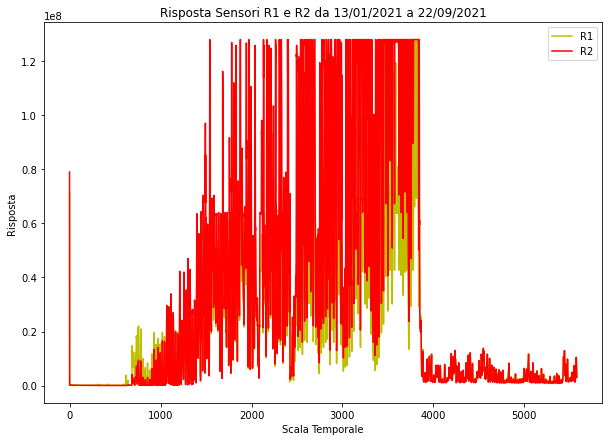

In [34]:
fig = plt.figure(figsize=(10,7))
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico,prova16.R1, 'y', label='R1')
plt.plot(supportografico, prova16.R2, 'r', label='R2')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
plt.title('Risposta Sensori R1 e R2 da 13/01/2021 a 22/09/2021')
plt.xlabel('Scala Temporale')
plt.ylabel('Risposta')
plt.legend()
plt.savefig('R1R2.png', dpi=600, bbox_inches='tight')
plt.show()


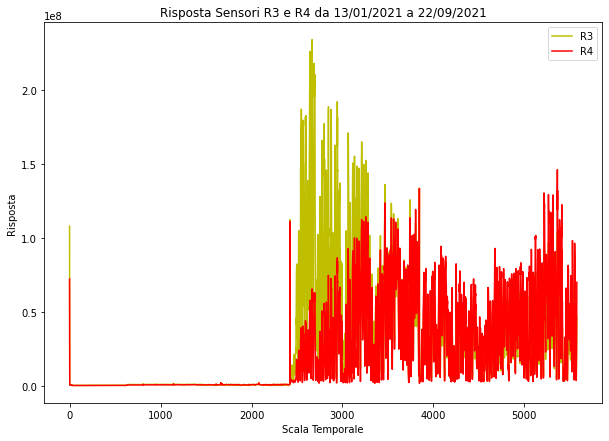

In [35]:
fig = plt.figure(figsize=(10,7))
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico,prova16.R3, 'y', label='R3')
plt.plot(supportografico, prova16.R4, 'r', label='R4')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
plt.title('Risposta Sensori R3 e R4 da 13/01/2021 a 22/09/2021')
plt.xlabel('Scala Temporale')
plt.ylabel('Risposta')
plt.legend()
plt.savefig('R3R4.png', dpi=600, bbox_inches='tight')
plt.show()



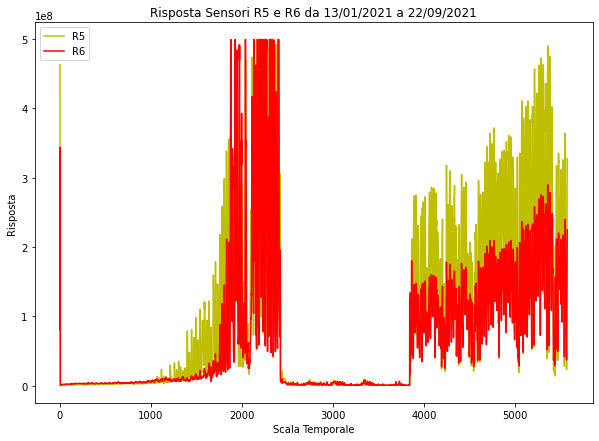

In [36]:
fig = plt.figure(figsize=(10,7))
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico,prova16.R5, 'y', label='R5')
plt.plot(supportografico, prova16.R6, 'r', label='R6')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
plt.title('Risposta Sensori R5 e R6 da 13/01/2021 a 22/09/2021')
plt.xlabel('Scala Temporale')
plt.ylabel('Risposta')
plt.legend()
plt.savefig('R5R6.png', dpi=600, bbox_inches='tight')
plt.show()



In [37]:
prova17 = prova16.loc[(prova16.R7 <  3 * 10**8)].loc[(prova16.R8 <  3 * 10**8)]

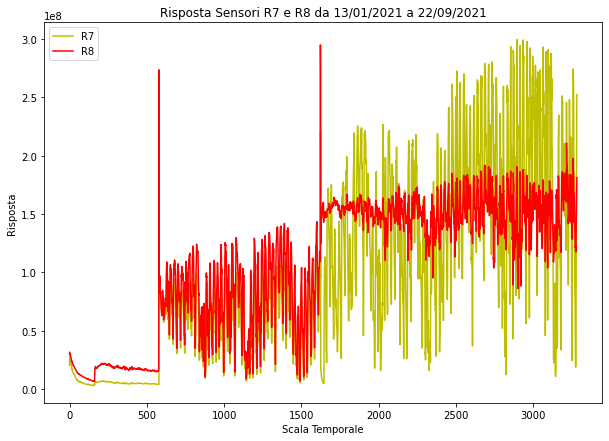

In [38]:
supportografico = range(len(prova17))

fig = plt.figure(figsize=(10,7))
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico,prova17.R7, 'y', label='R7')
plt.plot(supportografico, prova17.R8, 'r', label='R8')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
plt.title('Risposta Sensori R7 e R8 da 13/01/2021 a 22/09/2021')
plt.xlabel('Scala Temporale')
plt.ylabel('Risposta')
plt.legend()
plt.savefig('R7R8.png', dpi=600, bbox_inches='tight')
plt.show()


In [39]:
yparz = pd.merge(y,y2,how = "outer")
ytot = pd.merge(yparz,y4,how = "outer")


corrtot = ytot.corr()

corrtot.style.background_gradient(cmap='coolwarm')

In [40]:
ytot

Ozono  PM10  Biossido Zolfo  Biossido di Azoto  Ossido di Carbonio
0       7.0  34.0             7.0               81.0                 1.1
1      10.0  40.0             7.0               78.0                 0.9
2      17.0  38.0             5.0               64.0                 0.8
3      23.0  30.0             5.0               55.0                 0.7
4      21.0  28.0             5.0               56.0                 0.7
...     ...   ...             ...                ...                 ...
5559   34.0   9.0             2.0               15.0                 0.7
5560   40.0   8.0             1.0               16.0                 0.8
5561   49.0   9.0             1.0               18.0                 0.8
5562   63.0   9.0             1.0               13.0                 0.8
5563   59.0  10.0             1.0               20.0                 0.8

[5564 rows x 5 columns]

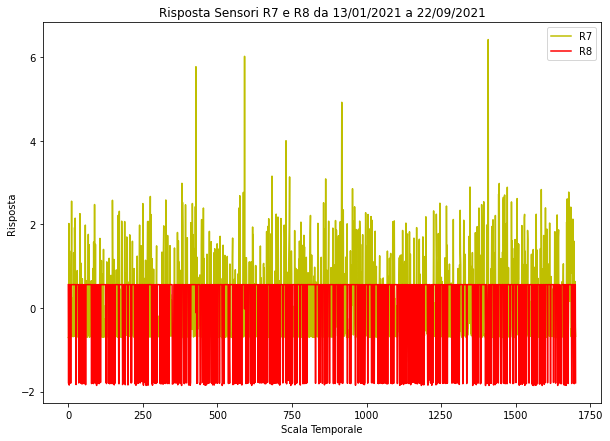

In [41]:
supportografico = range(len(X_train_scaled))

fig = plt.figure(figsize=(10,7))
t = np.arange(0, predictions.size, 1)
plt.plot(supportografico,X_train_scaled[:,6], 'y', label='R7')
plt.plot(supportografico, X_train_scaled[:,7], 'r', label='R8')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
plt.title('Risposta Sensori R7 e R8 da 13/01/2021 a 22/09/2021')
plt.xlabel('Scala Temporale')
plt.ylabel('Risposta')
plt.legend()
plt.savefig('R7R8.png', dpi=600, bbox_inches='tight')
plt.show()


In [42]:
df8

R1            R2            R3            R4            R5  \
9     7.131916e+07  7.902359e+07  1.078199e+08  7.204421e+07  4.624436e+08   
10    1.218931e+05  1.388258e+05  7.281900e+05  6.045887e+05  1.945371e+08   
11    1.666616e+05  1.725927e+05  6.107362e+05  5.313485e+05  2.733031e+08   
12    1.782083e+05  1.697632e+05  5.989559e+05  5.229369e+05  6.281952e+07   
13    6.142613e+05  1.656729e+05  5.967311e+05  5.181528e+05  1.773463e+07   
...            ...           ...           ...           ...           ...   
2562  3.154827e+06  3.866846e+06  2.585224e+06  2.252611e+06  1.155901e+07   
2563  3.383900e+06  4.159279e+06  2.751506e+06  2.334740e+06  1.127265e+07   
2564  2.660721e+06  3.488866e+06  2.874168e+06  2.441202e+06  1.082136e+07   
2565  2.542060e+06  3.330329e+06  3.076428e+06  2.598593e+06  1.047149e+07   
2566  3.303117e+06  4.130461e+06  3.013671e+06  2.455530e+06  1.060186e+07   

                R6            R7            R8          T1         T2  \
9     8.162741e+07  3.138289e+08  3.148292e+08   65.830769  65.038462   
10    2.202666e+08  2.043034e+07  3.140541e+07  101.164706  99.211765   
11    3.437187e+08  2.742710e+07  2.947224e+07  101.538333  99.500000   
12    3.228352e+07  2.781584e+07  3.047974e+07  101.556667  99.521667   
13    3.389715e+05  2.704933e+07  3.034089e+07  101.188333  99.570000   
...            ...           ...           ...         ...        ...   
2562  5.381098e+06  4.370647e+08  3.715220e+08  101.683051  99.547458   
2563  5.245826e+06  4.492767e+08  3.822018e+08  101.685000  99.561667   
2564  5.046791e+06  4.467842e+08  3.802376e+08  101.690000  99.561667   
2565  4.915955e+06  4.650282e+08  3.921127e+08  101.690000  99.565000   
2566  4.970360e+06  4.731346e+08  4.010762e+08  101.711667  99.561667   

             T3         T4         T5          T6          T7          T8  \
9     69.907692  70.092308  64.992308   69.500000   72.823077   71.323077   
10    87.739216  87.109804  38.782353  100.129412  108.049020  105.184314   
11    88.008333  87.396667  39.630000  102.476667  108.445000  106.568333   
12    88.051667  87.436667  41.295000  107.513333  108.525000  106.630000   
13    88.093333  87.468333  41.320000  107.570000  108.561667  106.668333   
...         ...        ...        ...         ...         ...         ...   
2562  81.945763  82.981356  89.227119   88.050847   84.118644   82.672881   
2563  81.983333  82.990000  89.210000   88.053333   84.148333   82.671667   
2564  81.983333  82.996667  89.213333   88.053333   84.161667   82.690000   
2565  81.975000  83.000000  89.221667   88.055000   84.150000   82.666667   
2566  81.990000  83.020000  89.231667   88.075000   84.173333   82.690000   

       TEMP_BME       TEMP    HUM_BME        HUM  
9     23.184615  26.807692  25.553846  22.553846  
10    38.858824  41.113725  13.398039  11.288235  
11    43.971667  46.070000   6.635000   5.113333  
12    44.701667  46.823333   6.263333   4.701667  
13    45.615000  47.765000   6.041667   4.460000  
...         ...        ...        ...        ...  
2562  39.105085  41.233898  19.750847  18.703390  
2563  39.285000  41.440000  19.720000  18.705000  
2564  39.688333  41.778333  19.476667  18.478333  
2565  39.460000  41.613333  19.813333  18.833333  
2566  39.876667  41.951667  19.386667  18.400000  

[2432 rows x 20 columns]

In [43]:
df8 = read_csv("13gen_29apr_appa1.csv",sep="\t",header=0)
df8 = df8.drop("Time",axis = 1)
df8 = df8.apply(pd.to_numeric, errors='coerce')
df8 = df8.dropna()

corrcomplete = df8.corr()

corrcomplete.style.background_gradient(cmap='coolwarm')

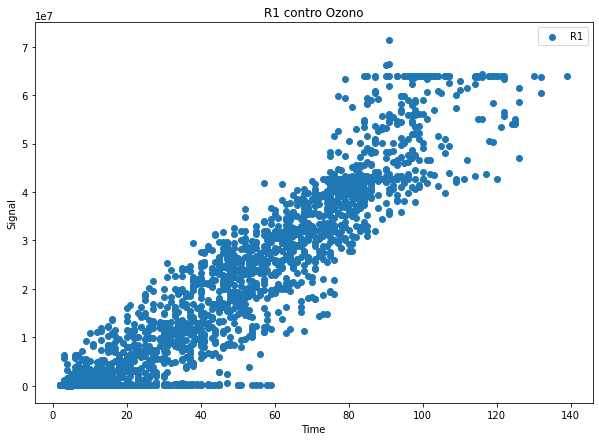

In [44]:
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
#ax=ax2.twinx()
ax2.scatter(df8.Ozono[3:-10], df8.R1[3:-10], label='R1')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
ax2.set_title('R1 contro Ozono')
ax2.set_xlabel('Time')
ax2.set_ylabel('Signal')
ax2.legend()
plt.show()


In [45]:
import scipy.stats
Valori = scipy.stats.linregress(df8["R1"],df8["Ozono"])
print(Valori)

LinregressResult(slope=1.6357752042986125e-06, intercept=12.27409316142774, rvalue=0.9347655045257603, pvalue=0.0, stderr=1.2611612791342059e-08, intercept_stderr=0.32670283131958716)


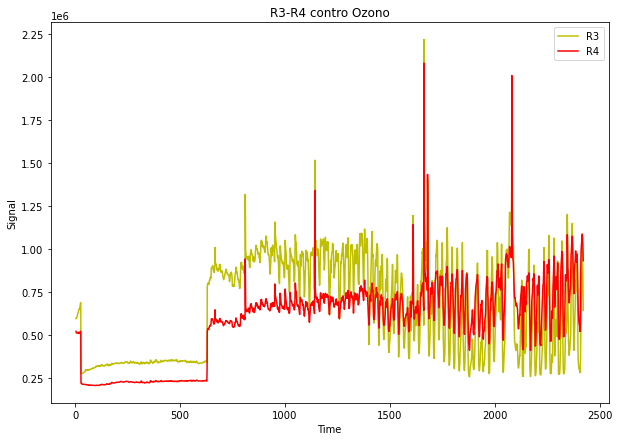

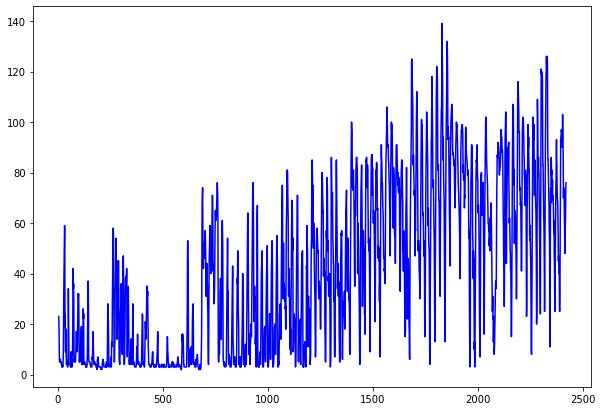

In [46]:
supportografico = range(len(df8) )
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
#ax=ax2.twinx()
t = np.arange(0, predictions.size, 1)
ax2.plot(supportografico[3:-10], df8.R3[3:-10], 'y', label='R3')
ax2.plot(supportografico[3:-10], df8.R4[3:-10], 'r', label='R4')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
ax2.set_title('R3-R4 contro Ozono')
ax2.set_xlabel('Time')
ax2.set_ylabel('Signal')
ax.set_ylabel('$O_3$ Concentration')
ax2.legend()
ax.legend()
plt.show()

fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot()

ax.plot(supportografico[3:-10], df8.Ozono[3:-10], 'b', label='Ozono')
plt.show()


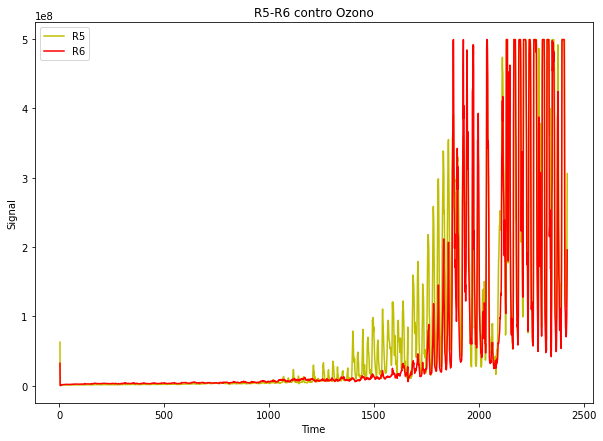

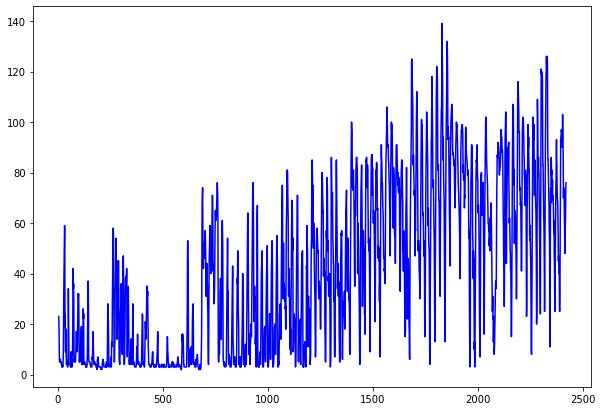

In [47]:
supportografico = range(len(df8) )
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
#ax=ax2.twinx()
t = np.arange(0, predictions.size, 1)
ax2.plot(supportografico[3:-10], df8.R5[3:-10], 'y', label='R5')
ax2.plot(supportografico[3:-10], df8.R6[3:-10], 'r', label='R6')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
ax2.set_title('R5-R6 contro Ozono')
ax2.set_xlabel('Time')
ax2.set_ylabel('Signal')
ax.set_ylabel('$O_3$ Concentration')
ax2.legend()
ax.legend()
plt.show()

fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot()

ax.plot(supportografico[3:-10], df8.Ozono[3:-10], 'b', label='Ozono')
plt.show()


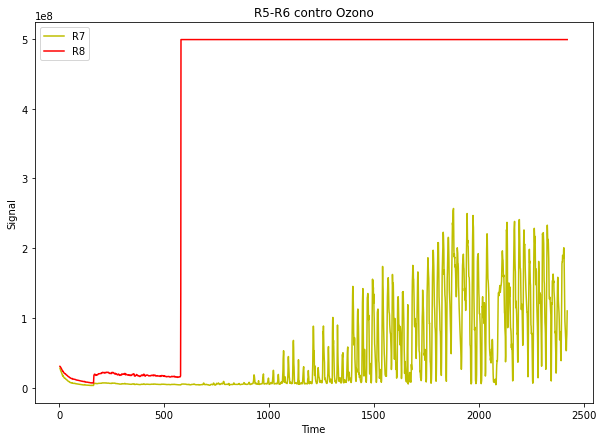

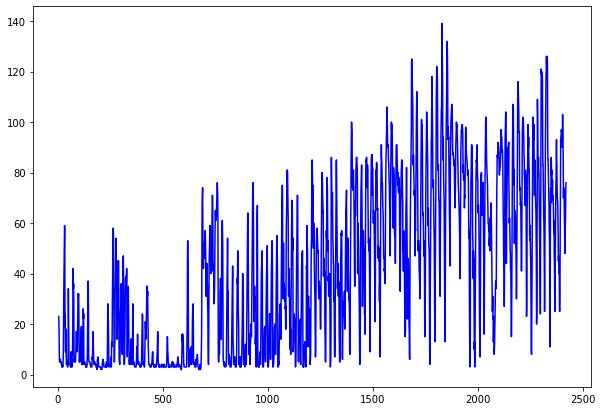

In [48]:
supportografico = range(len(df8) )
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
#ax=ax2.twinx()
t = np.arange(0, predictions.size, 1)
ax2.plot(supportografico[3:-10], df8.R7[3:-10], 'y', label='R7')
ax2.plot(supportografico[3:-10], df8.R8[3:-10], 'r', label='R8')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
ax2.set_title('R5-R6 contro Ozono')
ax2.set_xlabel('Time')
ax2.set_ylabel('Signal')
ax.set_ylabel('$O_3$ Concentration')
ax2.legend()
ax.legend()
plt.show()

fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot()

ax.plot(supportografico[3:-10], df8.Ozono[3:-10], 'b', label='Ozono')
plt.show()


In [49]:
df8 = read_csv("13gen_29apr_appa1.csv",sep="\t",header=0)
df8 = df8.dropna()
df8

Time            R1            R2            R3  \
9     Jan 13 2021 09:00:00  7.131916e+07  7.902359e+07  1.078199e+08   
10    Jan 13 2021 10:00:00  1.218931e+05  1.388258e+05  7.281900e+05   
11    Jan 13 2021 11:00:00  1.666616e+05  1.725927e+05  6.107362e+05   
12    Jan 13 2021 12:00:00  1.782083e+05  1.697632e+05  5.989559e+05   
13    Jan 13 2021 13:00:00  6.142613e+05  1.656729e+05  5.967311e+05   
...                    ...           ...           ...           ...   
2562  Apr 29 2021 19:00:00  3.154827e+06  3.866846e+06  2.585224e+06   
2563  Apr 29 2021 20:00:00  3.383900e+06  4.159279e+06  2.751506e+06   
2564  Apr 29 2021 21:00:00  2.660721e+06  3.488866e+06  2.874168e+06   
2565  Apr 29 2021 22:00:00  2.542060e+06  3.330329e+06  3.076428e+06   
2566  Apr 29 2021 23:00:00  3.303117e+06  4.130461e+06  3.013671e+06   

                R4            R5            R6            R7            R8  \
9     7.204421e+07  4.624436e+08  8.162741e+07  3.138289e+08  3.148292e+08   
10    6.045887e+05  1.945371e+08  2.202666e+08  2.043034e+07  3.140541e+07   
11    5.313485e+05  2.733031e+08  3.437187e+08  2.742710e+07  2.947224e+07   
12    5.229369e+05  6.281952e+07  3.228352e+07  2.781584e+07  3.047974e+07   
13    5.181528e+05  1.773463e+07  3.389715e+05  2.704933e+07  3.034089e+07   
...            ...           ...           ...           ...           ...   
2562  2.252611e+06  1.155901e+07  5.381098e+06  4.370647e+08  3.715220e+08   
2563  2.334740e+06  1.127265e+07  5.245826e+06  4.492767e+08  3.822018e+08   
2564  2.441202e+06  1.082136e+07  5.046791e+06  4.467842e+08  3.802376e+08   
2565  2.598593e+06  1.047149e+07  4.915955e+06  4.650282e+08  3.921127e+08   
2566  2.455530e+06  1.060186e+07  4.970360e+06  4.731346e+08  4.010762e+08   

              T1  ...          T8   TEMP_BME       TEMP    HUM_BME        HUM  \
9      65.830769  ...   71.323077  23.184615  26.807692  25.553846  22.553846   
10    101.164706  ...  105.184314  38.858824  41.113725  13.398039  11.288235   
11    101.538333  ...  106.568333  43.971667  46.070000   6.635000   5.113333   
12    101.556667  ...  106.630000  44.701667  46.823333   6.263333   4.701667   
13    101.188333  ...  106.668333  45.615000  47.765000   6.041667   4.460000   
...          ...  ...         ...        ...        ...        ...        ...   
2562  101.683051  ...   82.672881  39.105085  41.233898  19.750847  18.703390   
2563  101.685000  ...   82.671667  39.285000  41.440000  19.720000  18.705000   
2564  101.690000  ...   82.690000  39.688333  41.778333  19.476667  18.478333   
2565  101.690000  ...   82.666667  39.460000  41.613333  19.813333  18.833333   
2566  101.711667  ...   82.690000  39.876667  41.951667  19.386667  18.400000   

      PM10  Biossido di Azoto  Ozono  Biossido Zolfo  Ossido di Carbonio  
9     34.0               81.0    7.0             7.0                 1.1  
10    40.0               78.0   10.0             7.0                 0.9  
11    38.0               64.0   17.0             5.0                 0.8  
12    30.0               55.0   23.0             5.0                 0.7  
13    28.0               56.0   21.0             5.0                 0.7  
...    ...                ...    ...             ...                 ...  
2562   9.0               28.0   51.0             1.0                 0.9  
2563  10.0               28.0   47.0             1.0                 0.8  
2564  11.0               30.0   34.0             1.0                 0.8  
2565  12.0               28.0   35.0             1.0                 0.8  
2566   9.0               17.0   47.0             1.0                 0.8  

[2432 rows x 26 columns]

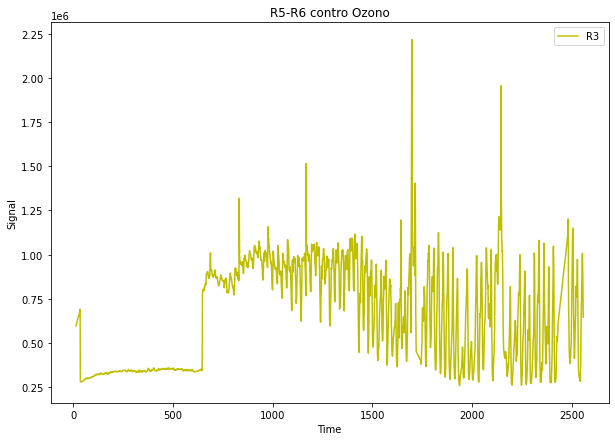

In [50]:
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
#ax=ax2.twinx()
t = np.arange(0, predictions.size, 1)
ax2.plot(df8.index[5:-10], df8.R3[5:-10], 'y', label='R3')
#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
ax2.set_title('R5-R6 contro Ozono')
ax2.set_xlabel('Time')
ax2.set_ylabel('Signal')
ax.set_ylabel('$O_3$ Concentration')
ax2.legend()
ax.legend()
plt.show()


In [51]:
df8.loc[646:650].R4

646    233865.866667
647    289130.450000
648    523206.016949
649    534120.300000
650    538214.650000
Name: R4, dtype: float64

In [52]:
df8.loc[646:650].Time

646    Feb 08 2021 22:00:00
647    Feb 08 2021 23:00:00
648    Feb 09 2021 00:00:00
649    Feb 09 2021 01:00:00
650    Feb 09 2021 02:00:00
Name: Time, dtype: object

In [53]:
dfappa2 = read_csv("../APPA2/1lug_22set_appa.csv",sep="\t",header=0)
dfappa2 = dfappa2.drop("Time",axis = 1)
dfappa2 = dfappa2.apply(pd.to_numeric, errors='coerce')
dfappa2 = dfappa2.dropna()


In [54]:
dfappa1 = read_csv("1lug_22set_appa1.csv",sep="\t",header=0)
dfappa1 = dfappa1.drop("Time",axis = 1)
dfappa1 = dfappa1.apply(pd.to_numeric, errors='coerce')
dfappa1 = dfappa1.dropna()


In [55]:
dfappa12 = read_csv("29apr_1lug_appa1.csv",sep="\t",header=0)
dfappa12 = dfappa12.drop("Time",axis = 1)
dfappa12 = dfappa12.apply(pd.to_numeric, errors='coerce')
dfappa12 = dfappa12.dropna()

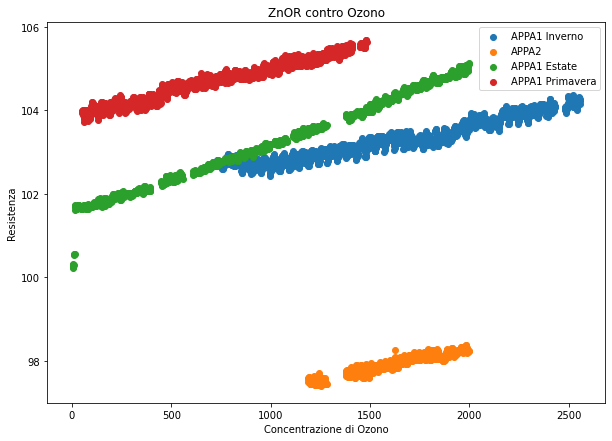

In [56]:
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
#ax=ax2.twinx()
ax2.scatter(df8.index[700:-10], df8.T1[700:-10], label='APPA1 Inverno')
ax2.scatter(dfappa2.index[1000:-10], dfappa2.T4[1000:-10], label='APPA2')
ax2.scatter(dfappa1.index[3:-10], dfappa1.T5[3:-10], label='APPA1 Estate')
ax2.scatter(dfappa12.index[50:-50], dfappa12.T1[50:-50], label='APPA1 Primavera')

#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
ax2.set_title('ZnOR contro Ozono')
ax2.set_xlabel('Concentrazione di Ozono')
ax2.set_ylabel('Resistenza')
ax2.legend()
#plt.savefig('Inverno+APPA2.png', dpi=600, bbox_inches='tight')
plt.show()


AttributeError: 'DataFrame' object has no attribute 'R1'

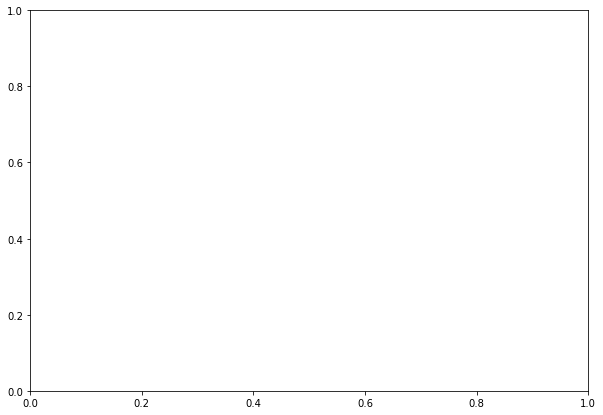

In [48]:
fig = plt.figure(figsize=(10,7))
ax2 = fig.add_subplot()
#ax=ax2.twinx()

ax2.scatter(df8.Ozono[700:-10], StandardScaler(df8.R1[700:-10]), label='APPA1 Inverno')
ax2.scatter(dfappa2.Ozono[1000:-10], StandardScaler(dfappa2.R4[1000:-10]), label='APPA2')
ax2.scatter(dfappa1.Ozono[3:-10], StandardScaler(dfappa1.R6[3:-10]), label='APPA1 Estate Canale 6')
ax2.scatter(dfappa1.Ozono[3:-10], StandardScaler(dfappa1.R5[3:-10]), label='APPA1 Estate Canale 5')

ax2.scatter(dfappa12.Ozono[50:-50], StandardScaler(dfappa12.R1[50:-50]), label='APPA1 Primavera')

#plt.plot(supportografico, predictions[:100,0], 'r', label='Prediction')
ax2.set_title('ZnOR contro Ozono')
ax2.set_xlabel('Concentrazione di Ozono')
ax2.set_ylabel('Resistenza')
ax2.legend()
#plt.savefig('Inverno+APPA2.png', dpi=600, bbox_inches='tight')
plt.show()


In [58]:
import scipy.stats
Valori = scipy.stats.linregress(dfappa2["R4"][1000:],dfappa2["Ozono"][1000:])
print(Valori)

LinregressResult(slope=1.6911308338005132e-06, intercept=12.34733708536482, rvalue=0.8546607930182337, pvalue=2.6857254249765824e-206, stderr=3.836608524167599e-08, intercept_stderr=1.3936203420833575)


In [59]:
Valori2 = scipy.stats.linregress(df8["R1"][100:-100],df8["Ozono"][100:-100])
print(Valori2)

LinregressResult(slope=1.64899610990667e-06, intercept=11.934790804586946, rvalue=0.9408309875385805, pvalue=0.0, stderr=1.2577566024680086e-08, intercept_stderr=0.3271380715358787)
